In [1]:
%matplotlib notebook
import numpy as np
import time
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline
import scipy.interpolate as interpolate

In [2]:
def load_data(num):
    coords = np.loadtxt('N_list.txt', skiprows=1)
    data = np.loadtxt('Uy_list_%d.txt' % num, skiprows=1)

    x = coords[:,1]
    y = coords[:,2]
    z = coords[:,3]
    dy = data[:,1]
    print(data.shape)

    # plt.figure()
    # plt.plot(x)
    # plt.figure()
    # plt.plot(z)

    xx = np.linspace(np.min(x), np.max(x), 1024)
    zz = np.linspace(np.min(z), np.max(z), 1024)
    xx,zz = np.meshgrid(xx,zz)

    # f = interpolate.interp2d(z,x,dy)
    dy2 = interpolate.griddata((x,z),dy,(xx,zz), fill_value=0)

    dy_symmetrize = np.concatenate((dy2,np.flipud(dy2)),axis=0)
    dy_symmetrize = np.concatenate((dy_symmetrize,np.fliplr(dy_symmetrize)),axis=1)

    xx2 = np.linspace(np.min(x), -np.min(x), 2048)
    zz2 = np.linspace(np.min(z), -np.min(z), 2048)
    xx2,zz2 = np.meshgrid(xx2,zz2)
    
    return dy_symmetrize, xx2, zz2

def plot_data(num, dy, xx, zz):
    plt.figure(figsize=(7 ,6))
    ax_im = plt.subplot2grid((6,7), (1,0), colspan=5, rowspan=3)
    ax_x = plt.subplot2grid((6,7), (4,0), colspan=5, rowspan=2)
    ax_y = plt.subplot2grid((6,7), (1,5), colspan=2, rowspan=3)
    ax_colorbar = plt.subplot2grid((6,7), (4,5), colspan=1, rowspan=2)
    im_profile = ax_im.imshow(dy*1e6+125, extent=(-7.5,7.5,-.75,.75),aspect=(20/4))
    ax_im.set_xlabel('Tangential coordinates (mm)')
    ax_im.set_ylabel('Sagittal coordinates (mm)')
    ax_x.plot(xx[0,:],dy[1024,:]*1e6+125)
    ax_x.set_ylabel('Height (nm)')
    ax_x.grid()
    ax_y.plot(dy[:,1024]*1e6+125,zz[:,0])
    ax_y.set_xlabel('Height (nm)')
    ax_y.grid()
    plt.colorbar(im_profile, cax=ax_colorbar, label='Height error (nm)')
    ax_im.set_title('Case %d' % num)

In [3]:
dy1, xx, zz = load_data(1)
dy2, xx, zz = load_data(2)
dy3, xx, zz = load_data(3)
shapes = [None,dy1*1e6,dy2*1e6,dy3*1e6]

(3947, 2)
(3947, 2)
(3947, 2)


In [4]:
theta = 800e-9/np.pi/200e-6

In [5]:
1/10e-3

100.0

<IPython.core.display.Javascript object>


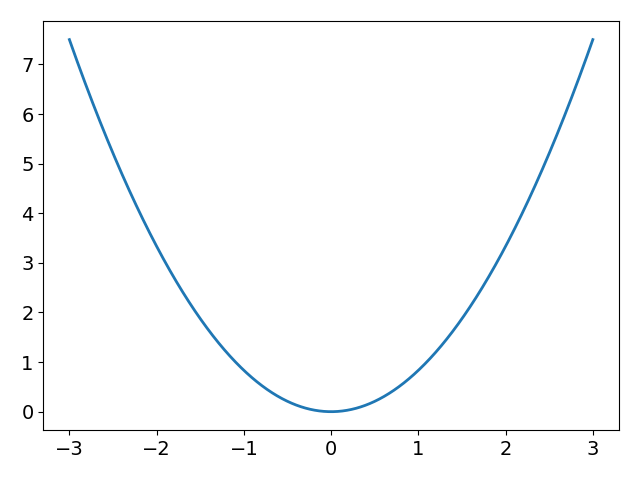

In [7]:
x = np.linspace(-3e-3,3e-3,2048)

plt.figure()
plt.plot(x*1e3,x**2/(2*600)*1e9)

<IPython.core.display.Javascript object>


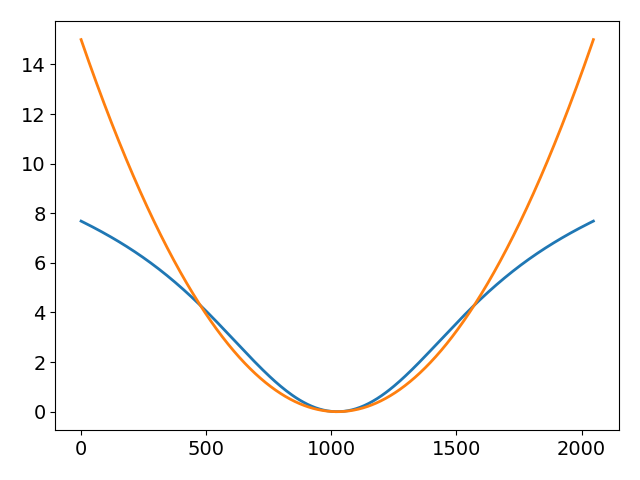

In [8]:
plt.figure()
plt.plot(dy1[1024,:]*1e6)
plt.plot(x**2/(2*300)*1e9)

In [57]:
beta0 = mono_beamline.c2.beta0
alpha = mono_beamline.c2.alpha

print(beta0)
print(alpha)

0.23448464050278972
1.2641101510361068


In [59]:
1/np.sin(alpha)*3*2

6.2936672349962635

In [10]:
R = 10000
beamz = np.linspace(0,10000,100)
beamz = 100000
R = np.linspace(0,10000,100)
f1 = np.sin(alpha) ** 2 / (
                    (np.sin(beta0) + np.sin(alpha)) / R - np.sin(beta0) ** 2 / beamz)

f2 = np.sin(beta0) ** 2 / (
                    (np.sin(alpha) + np.sin(beta0)) / R - np.sin(alpha) ** 2 / beamz)

# print(f1)
# print(f2)

plt.figure()
plt.plot(R,f2)

# print(f1/f2)

NameError: name 'alpha' is not defined

### Beam parameters

In [76]:
# number of sampling points
N = 2048
# photon energy in eV
E0 = 9481

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 30e-6,
    'sigma_y': 30e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 650-26
}

### Define beamline

In [63]:
def define_beamline(E0,slit_width,m2_p=175.332,shape=None):
    # crystal asymmetry angle
 
    z_s = 650

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=184+z_s, FOV=2e-3, N=256)
    
    m1 = optics.CurvedMirror('m1',p=185,q=-58,length=1,z=185+z_s,alpha=2.65e-3)
    
    m2 = optics.CurvedMirror('m2',p=m2_p,q=100000,length=1,z=300+z_s,alpha=2.65e-3,orientation=2)
    
    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=m2.z+2, FOV=5e-3, N=256)
    
#     crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=931, E0=E0,
#                               alphaAsym=0, orientation=0, pol='s', delta=0.e-6)
    
    asym = 17*np.pi/180
    c1 = optics.Crystal('HHLM1', hkl=[2,2,0], length=.1, width=20e-3, z=305+z_s, alphaAsym=-asym, E0=E0, 
                        orientation=0, pol='s')
    imc1 = optics.PPM('imc1', FOV=20e-3,N=256,z=c1.z+.01)
    c2 = optics.Crystal('HHLM2', hkl=[4,4,0], length=.1, width=20e-3, z=c1.z+139e-3,E0=E0,orientation=2,pol='s')
    c3 = optics.Crystal('HHLM3', hkl=[4,4,0], length=.1, width=20e-3, z=c1.z+361e-3, E0=E0, orientation=0,pol='s')
    c4 = optics.Crystal('HHLM4', hkl=[2,2,0], length=.1, width=20e-3, z=c1.z+.5, E0=E0, orientation=2, pol='s',
                       alphaAsym=asym)
    
    im3 = optics.PPM('im3', z=c4.z+1,FOV=4e-3,N=256)
    
    # asymmetry angle for 4f
    alphaAsym = 29.5*np.pi/180
    # crystal reflection hkl index
    hkl = [4,4,0]
    
    # distance between crystals and CRLs
    f1 = 10.
    # f1 = 10.0
    # distance between CRLs and focus
    f2 = 10.
    
    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=z_s+310, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=3e-3, width=20e-3, z=crystal1.z+.05, E0=E0,alphaAsym=alphaAsym, 
                              orientation=2,pol='s', delta=0e-6,shapeError=shape)
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im_c2 = optics.PPM('im_c2', z=crystal2.z +.1, FOV=4e-3, N=1024)

    # CRL with ~10 meter focal length (modeled as single element for now)
    hrm_m1 = optics.CurvedMirror('hrm_m1', z=crystal2.z+f1, p=100000, q=f1, length=.3, alpha=3e-3,orientation=0)
    # crl1 = optics.CRL('crl1', z=crystal2.z+f1, E0=E0, f=10, roc=21e-6, diameter=5e-3)

    # viewing point downstream of first crl
    im1 = optics.PPM('im1', z=hrm_m1.z+.1,N=256,FOV=2e-3)

    # viewing point at focus
    focus = optics.PPM('focus', z=hrm_m1.z+f2, FOV=300e-6, N=256)

    # slit at focus
    slit = optics.Slit('slit', z=hrm_m1.z+f2 + 1e-3, x_width=slit_width, y_width=2e-3)
#     slit = optics.Slit('slit', z=hrm_m1.z+f2 + 1e-3, x_width=40e-6, y_width=2e-3)

    # second CRL with ~1 meter focal length, for collimation
#     crl2 = optics.CRL('crl2', z=crl1.z+2*f2, E0=E0, f=10, roc=21e-6, diameter=5e-3)
    hrm_m2 = optics.CurvedMirror('hrm_m2', z=hrm_m1.z+2*f2, p=f1, q=100000, length=.3, alpha=3e-3,orientation=2)
    # crl2 = optics.CRL('crl2', z=crl1.z+2*f2, E0=E0, f=10, roc=21e-6, diameter=5e-3)

    im_c3 = optics.PPM('im_c3', z=hrm_m2.z + f1-0.1, FOV=4e-3, N=256)

    # third crystal, symmetric reflection, same orientation as crystal2
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=hrm_m2.z+f1, E0=E0,alphaAsym=-alphaAsym, 
                              orientation=2,pol='s')

    imc3 = optics.PPM('imc3', z=crystal3.z + 1e-3, FOV=2e-3, N=256)

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crystal3.z+.05, E0=E0,alphaAsym=0, 
                                orientation=0,pol='s')

    # viewing point just downstream of monochromator
    im_out = optics.PPM('im_out', z=crystal4.z+.1, FOV=2e-3, N=256)

    # list of devices to propagate through
    
    telescope_devices = [im0,m1,m2,im2]
    HHLM_devices = [c1,imc1,c2,c3,c4,im3]
    HRM_devices = [crystal1,crystal2,im_c2, hrm_m1, im1, focus, slit, hrm_m2, im_c3, crystal3, crystal4, im_out]
    
#     devices = [im0,m1,im2,m2,c1,imc1,c2,c3,c4,im3]
    all_devices = telescope_devices + HHLM_devices + HRM_devices
#     all_devices = telescope_devices
    # devices = [im0,crystal1,crystal2,im_upstream, im1, crl1, focus, crl2, crystal3, crystal4, im2]

    # initialize beamline
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return mono_beamline

# No slit

FWHM in x: 50.063160108007565 microns
FWHM in y: 50.063160108007565 microns
FWHM Divergence (x): 1.6 μrad
FWHM Divergence (y): 1.6 μrad
21.62195189047939
21.62195189047939
x is focused
y is focused
b 0.08
b 1.00
b 1.00
b 11.78
b 1.00
b 4.10
crystal 2 incidence angle: 72.43 degrees
crystal 2 exit angle: 13.43 degrees
b 0.24
b 1.00
FWHM in x: 345.63486538461865 microns
FWHM in y: 345.63486538461865 microns
FWHM Divergence (x): 1.6 μrad
FWHM Divergence (y): 1.6 μrad
21.62195189047939
21.62195189047939
x is focused
y is focused
im0
zx: 210.000000
zy: 210.000000
azimuth 0.00 mrad
drift1
global_x 0.00
global_y 0.00
x intersect: 0.0000e+00
component x: 0.0000e+00
y intersect: 0.0000e+00
component y: 0.0000e+00
z intersect: 8.3500e+02
component z: 8.3500e+02
delta z: -0.00
zRx: 310570983.78 microns
zRy: 310570983.78 microns
remaining distance: 1000000.00 microns
goal for zx: 211000000.00 microns
current zx: 210000000.00 microns
goal for zy: 211000000.00 microns
current zy: 210000000.00 microns

/Users/seaberg/beamline/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/seaberg/Python/lcls_beamline_toolbox/lcls_beamline_toolbox/xraybeamline2d/optics1d.py:2445: RuntimeWarning: divide by zero encountered in double_scalars
  R = 1 / (2 * second_order*1e-9)



zy: 634.248218
azimuth 695.09 mrad
HHLM2
subtracting second order
0.38818359375
[-1.23112631e-12  0.00000000e+00  1.14519505e-12]
inf
Calculated distance to focus: 13919572.822489
offset 0.000000
z: -13919572.83
zRx: 5.25e+08
zRy: 5.29e+02
zx: -13919572.826558
zy: 634.248218
azimuth -803.40 mrad
drift7
global_x 0.73
global_y 0.00
x intersect: 4.9528e-01
component x: 4.9528e-01
y intersect: 0.0000e+00
component y: 0.0000e+00
z intersect: 9.5536e+02
component z: 9.5536e+02
delta z: 0.00
zRx: 524964090410167.06 microns
zRy: 528584988.36 microns
remaining distance: 319762.94 microns
goal for zx: -13919572506795.37 microns
current zx: -13919572826558.30 microns
goal for zy: 634567980.90 microns
current zy: 634248217.97 microns
current step size: 319762.94 microns
x remains focused
y stays unfocused
zx: -13919572.506795
zy: 635.207668
azimuth -803.40 mrad
HHLM3
subtracting second order
0.38818359375
[-1.23134836e-12  0.00000000e+00  1.14530607e-12]
inf
Calculated distance to focus: 13919572

1.0
[ 6.73605616e-12  0.00000000e+00 -2.12692086e-11]
inf
Calculated distance to focus: 88200.505241
offset 0.000000
z: -88200.50
zRx: 2.91e+06
zRy: 6.86e+02
zx: -88200.504986
zy: 771.877993
azimuth -1498.73 mrad
drift20
global_x 1.41
global_y 0.00
x intersect: 7.1669e-01
component x: 7.1669e-01
y intersect: 0.0000e+00
component y: 0.0000e+00
z intersect: 1.0001e+03
component z: 1.0001e+03
delta z: 0.01
zRx: 2910281489497.70 microns
zRy: 686096084.10 microns
remaining distance: 694379.78 microns
goal for zx: -88199810606.37 microns
current zx: -88200504986.16 microns
goal for zy: 772572373.23 microns
current zy: 771877993.44 microns
current step size: 694379.78 microns
x remains focused
y stays unfocused
zx: -88199.810606
zy: 773.961757
azimuth -1498.73 mrad
c4
subtracting second order
1.0
[ 1.62443392e-11  0.00000000e+00 -1.51101354e-11]
inf
Calculated distance to focus: 88199.810606
offset 0.000000
z: -88199.81
zRx: 2.91e+06
zRy: 6.89e+02
zx: -88199.810601
zy: 773.961757
azimuth -0.2

<IPython.core.display.Javascript object>


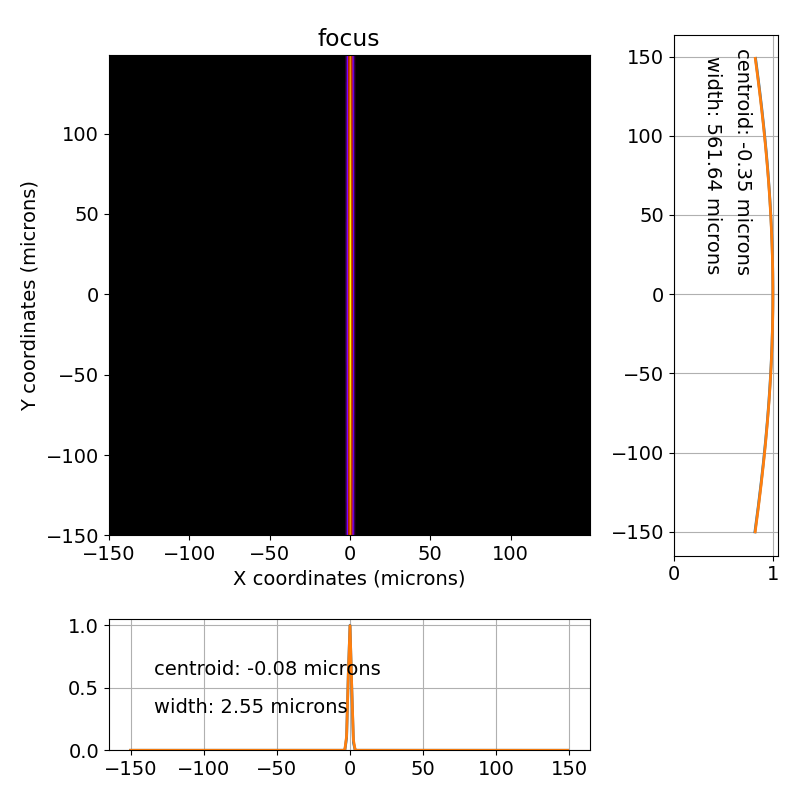

<IPython.core.display.Javascript object>


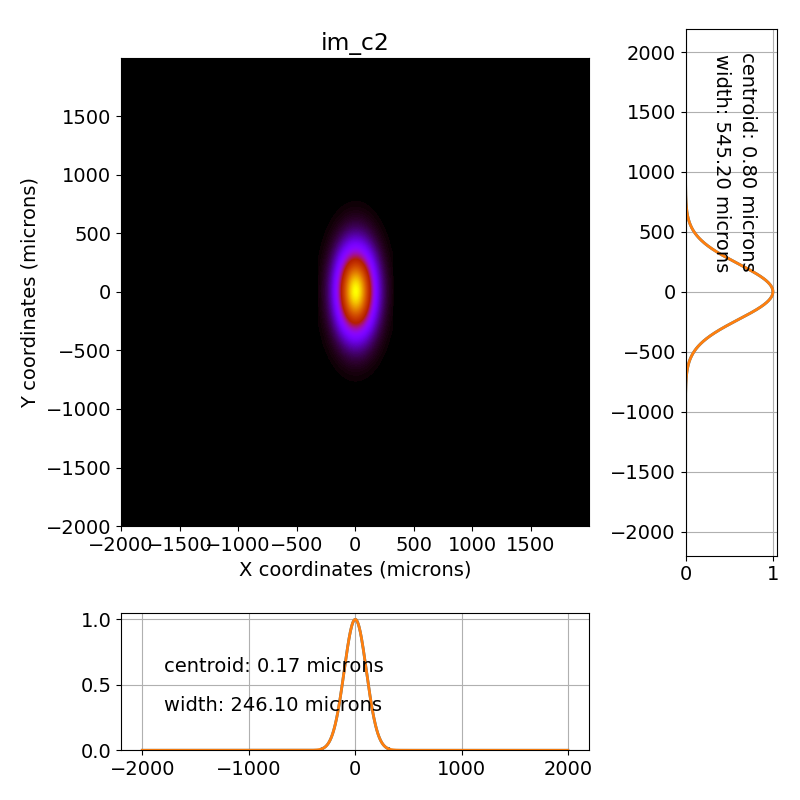

<IPython.core.display.Javascript object>


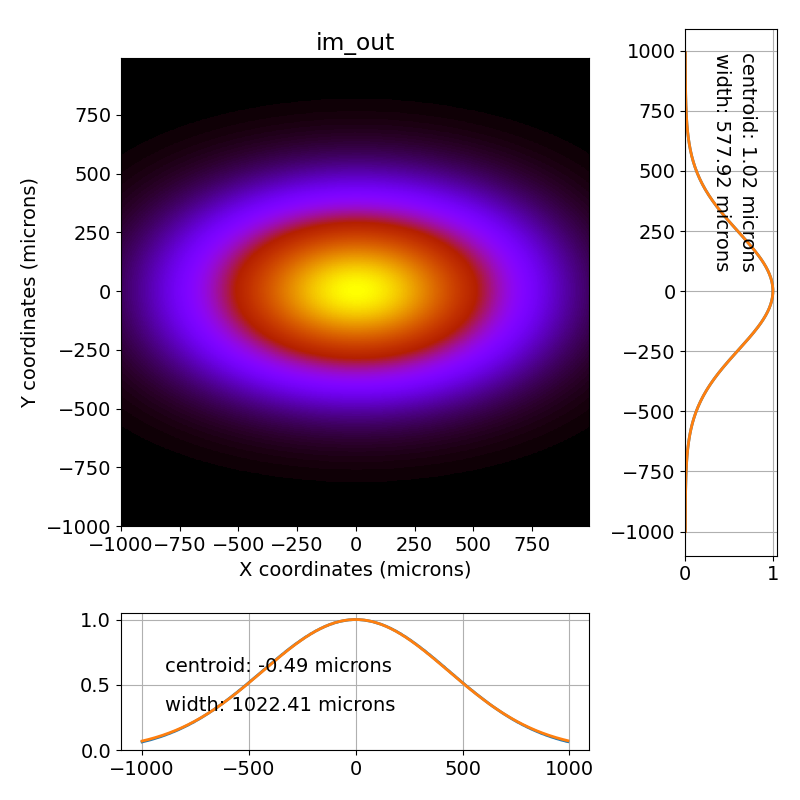

[<AxesSubplot:title={'center':'im_out'}, xlabel='X coordinates (microns)', ylabel='Y coordinates (microns)'>,
 <AxesSubplot:>,
 <AxesSubplot:>]

In [81]:
b1 = beam.Beam(beam_params=beam_params)
mono_beamline = define_beamline(E0,10e-6)
b2 = mono_beamline.propagate_beamline(b1)
# mono_beamline.im0.view_beam()
# mono_beamline.im_c2.view_beam()
mono_beamline.focus.view_beam()
mono_beamline.im_c2.view_beam()
mono_beamline.im_out.view_beam()

<IPython.core.display.Javascript object>


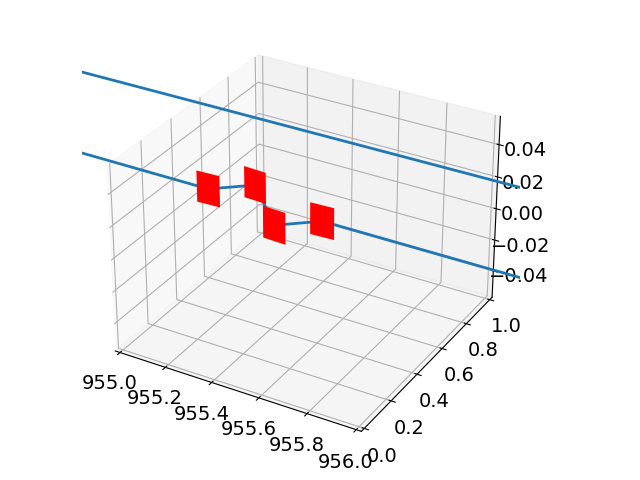

In [15]:
ax,zs = mono_beamline.draw_beamline()

In [16]:
# ax.set_xlim(960,1000)
ax.set_ylim(-2,3)
# ax.set_zlim(-.5,.5)

(-2.0, 3.0)

In [17]:
print(b2.xhat)
print(b2.yhat)
print(b2.zhat)

[9.99999970e-01 0.00000000e+00 2.42937444e-04]
[0. 1. 0.]
[-2.42937444e-04  0.00000000e+00  9.99999970e-01]


In [18]:
print(b2.global_azimuth)

-0.00024293744682471835


In [19]:
np.arccos(b2.zhat[2])*180/np.pi

0.013919290271292734

In [20]:
ax.set_xlim(955,956)
ax.set_ylim(0,1)

(0.0, 1.0)

<IPython.core.display.Javascript object>


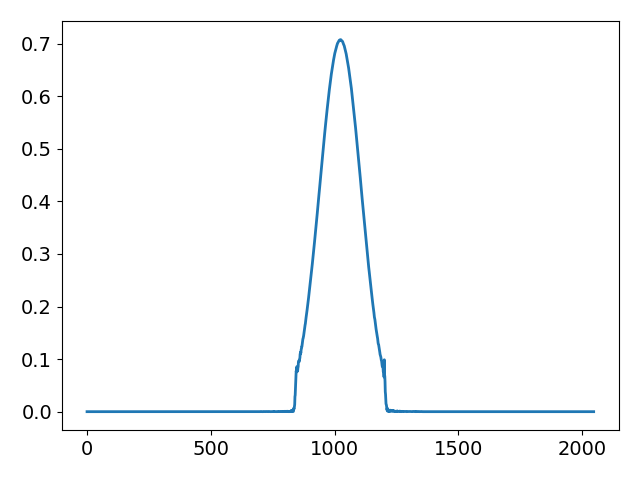

In [21]:
plt.figure()
plt.plot(np.abs(b2.wavex))

## Time-domain propagation

In [24]:
# reset central photon energy
beam_params['photonEnergy'] = 9481

# initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
# pulse = beam.Pulse(beam_params=beam_params, tau=1000, time_window=100000)
pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=400e-3, N=200)

print('Number of spectral components: {:d}'.format(pulse.N))

Number of spectral components: 200


In [25]:
%%capture cap
pulse.propagate(beamline=mono_beamline,screen_names=['im_out'])

In [30]:
%%capture cap

pulse_duration = np.zeros(21)
pulse_tilt = np.zeros(21)
spatial_chirp = np.zeros(21)
energy_bandwidth = np.zeros(21)

m1_q = np.linspace(-56,-62,21)

E0 = 9481

for i in range(21):
    # reset central photon energy
    beam_params['photonEnergy'] = E0

    # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
    # pulse = beam.Pulse(beam_params=beam_params, tau=1000, time_window=100000)
    pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=400e-3, N=200)
    mono_beamline = define_beamline(E0,200e-6,m1_q=m1_q[i],shape=shapes[1])
    
    pulse.propagate(beamline=mono_beamline,screen_names=['im_out'])
    c, pulse_duration[i] = pulse.pulse_duration('im_out')
    pulse_tilt[i] = pulse.pulsefront_tilt('im_out')
    spatial_chirp[i] = pulse.spatial_chirp('im_out')
    energy_bandwidth[i] = pulse.pulse_bandwidth('im_out')

In [36]:
%%capture cap

pulse_duration0 = np.zeros(21)
pulse_tilt0 = np.zeros(21)
spatial_chirp0 = np.zeros(21)
energy_bandwidth0 = np.zeros(21)

m1_q = np.linspace(-56,-62,21)

E0 = 9481

for i in range(21):
    # reset central photon energy
    beam_params['photonEnergy'] = E0

    # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
    # pulse = beam.Pulse(beam_params=beam_params, tau=1000, time_window=100000)
    pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=400e-3, N=200)
    mono_beamline = define_beamline(E0,200e-6,m1_q=m1_q[i])
    
    pulse.propagate(beamline=mono_beamline,screen_names=['im_out'])
    c, pulse_duration0[i] = pulse.pulse_duration('im_out')
    pulse_tilt0[i] = pulse.pulsefront_tilt('im_out')
    spatial_chirp0[i] = pulse.spatial_chirp('im_out')
    energy_bandwidth0[i] = pulse.pulse_bandwidth('im_out')

<IPython.core.display.Javascript object>


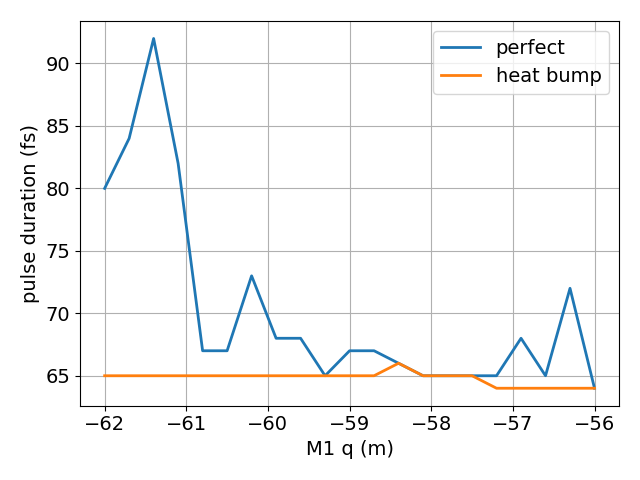

<IPython.core.display.Javascript object>


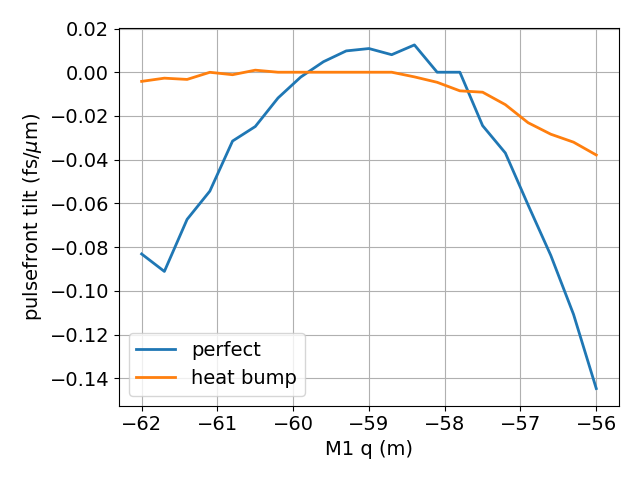

<IPython.core.display.Javascript object>


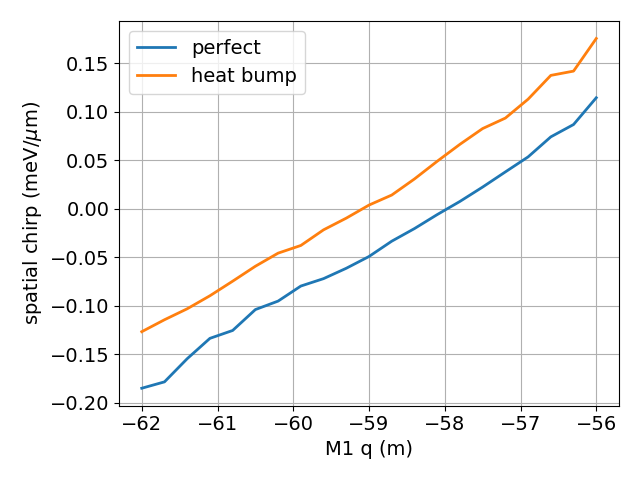

<IPython.core.display.Javascript object>


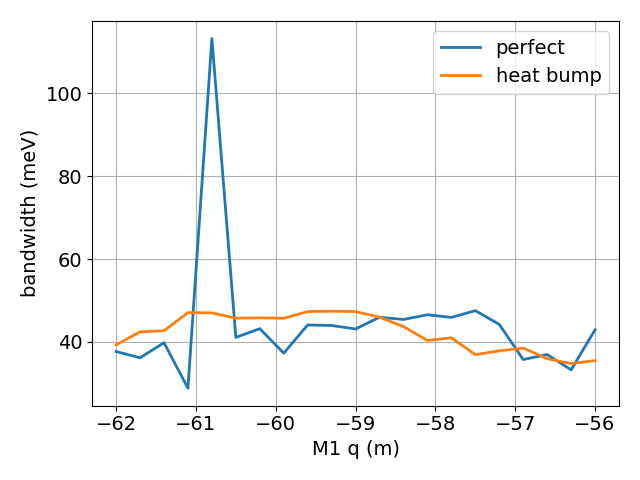

In [37]:
plt.figure()
plt.plot(m1_q, pulse_duration0,label='perfect')
plt.plot(m1_q, pulse_duration,label='heat bump')
plt.xlabel('M1 q (m)')
plt.ylabel('pulse duration (fs)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot(m1_q, pulse_tilt0,label='perfect')
plt.plot(m1_q, pulse_tilt,label='heat bump')
plt.xlabel('M1 q (m)')
plt.ylabel(r'pulsefront tilt (fs/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot(m1_q, spatial_chirp0*1000,label='perfect')
plt.plot(m1_q, spatial_chirp*1000,label='heat bump')
plt.xlabel('M1 q (m)')
plt.ylabel(r'spatial chirp (meV/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot(m1_q, energy_bandwidth0*1000,label='perfect')
plt.plot(m1_q, energy_bandwidth*1000,label='heat bump')
plt.xlabel('M1 q (m)')
plt.ylabel('bandwidth (meV)')
plt.grid()
plt.legend()
plt.tight_layout()

In [73]:
%%capture cap
E0 = 9481
# reset central photon energy
beam_params['photonEnergy'] = E0

# initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
# pulse = beam.Pulse(beam_params=beam_params, tau=1000, time_window=100000)
pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=400e-3, N=200)
mono_beamline = define_beamline(E0,200e-6)

pulse.propagate(beamline=mono_beamline,screen_names=['im_out'])

/Users/seaberg/Python/lcls_beamline_toolbox/lcls_beamline_toolbox/xraybeamline2d/beam1d.py:1346: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 8))


<IPython.core.display.Javascript object>


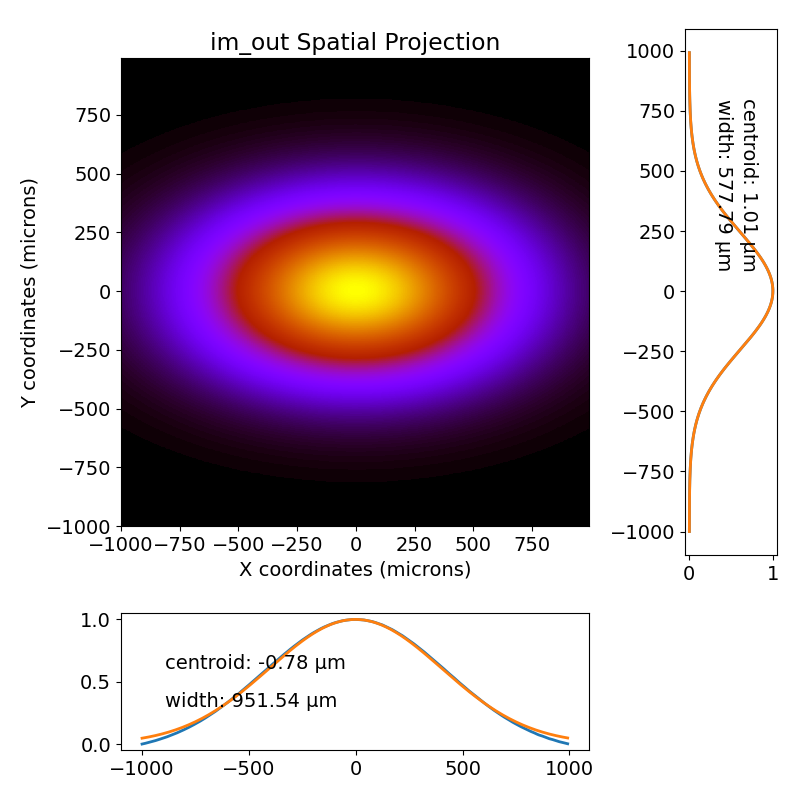

<IPython.core.display.Javascript object>


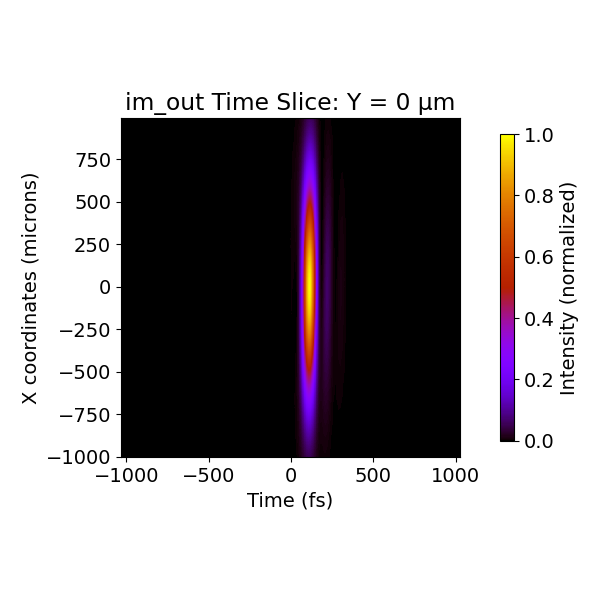

<IPython.core.display.Javascript object>


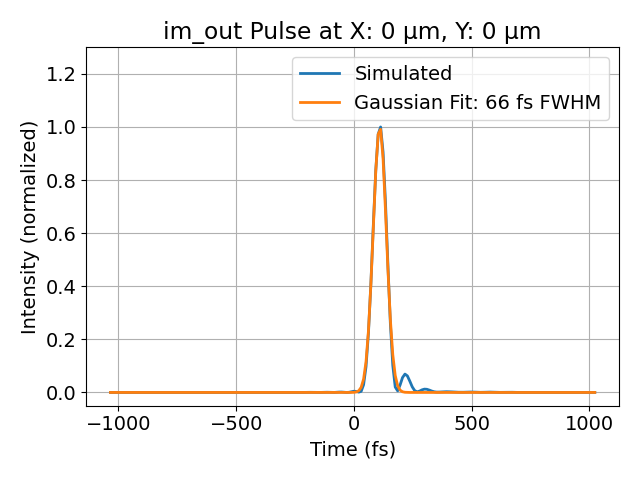

<IPython.core.display.Javascript object>


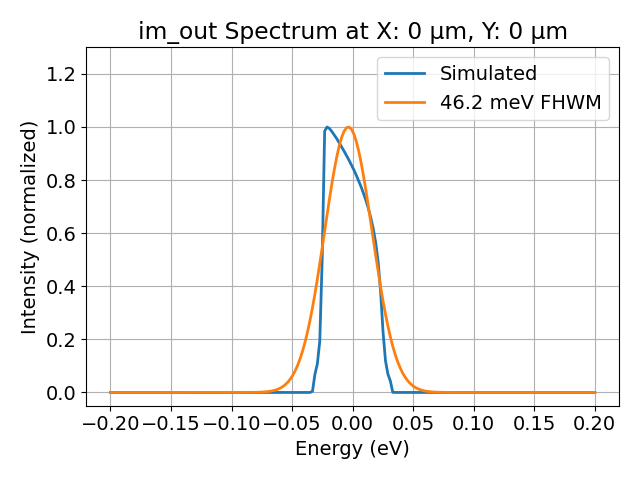

<IPython.core.display.Javascript object>


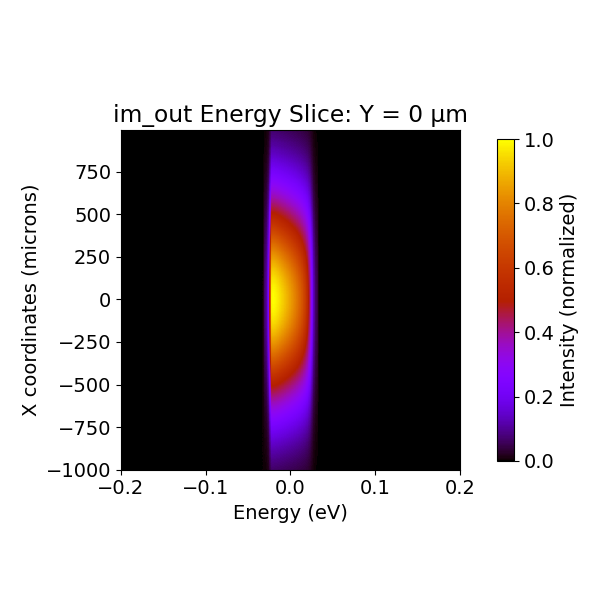

In [74]:
# pulse.plot_spectrum('im2')
pulse.imshow_projection('im_out')
pulse.imshow_time_slice('im_out')
pulse.plot_pulse('im_out')
pulse.plot_spectrum('im_out')
pulse.imshow_energy_slice('im_out')
plt.tight_layout()

# pulse.imshow_projection('focus')
# pulse.imshow_energy_slice('focus')

# pulse.imshow_projection('imc1')
# pulse.imshow_time_slice('imc1')
# pulse.imshow_time_slice('im3')
# pulse.imshow_energy_slice('im3')
# pulse.plot_pulse('im3')
# pulse.plot_spectrum('im3',show_fit=False)
# pulse.pulsefront_tilt('imc1')

In [43]:
%%capture cap
E0 = 9481
# reset central photon energy
beam_params['photonEnergy'] = E0

# initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
# pulse = beam.Pulse(beam_params=beam_params, tau=1000, time_window=100000)
pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=400e-3, N=200)
mono_beamline = define_beamline(E0,200e-6,m1_q=-59.2,shape=shapes[1])

pulse.propagate(beamline=mono_beamline,screen_names=['im_out'])

<IPython.core.display.Javascript object>


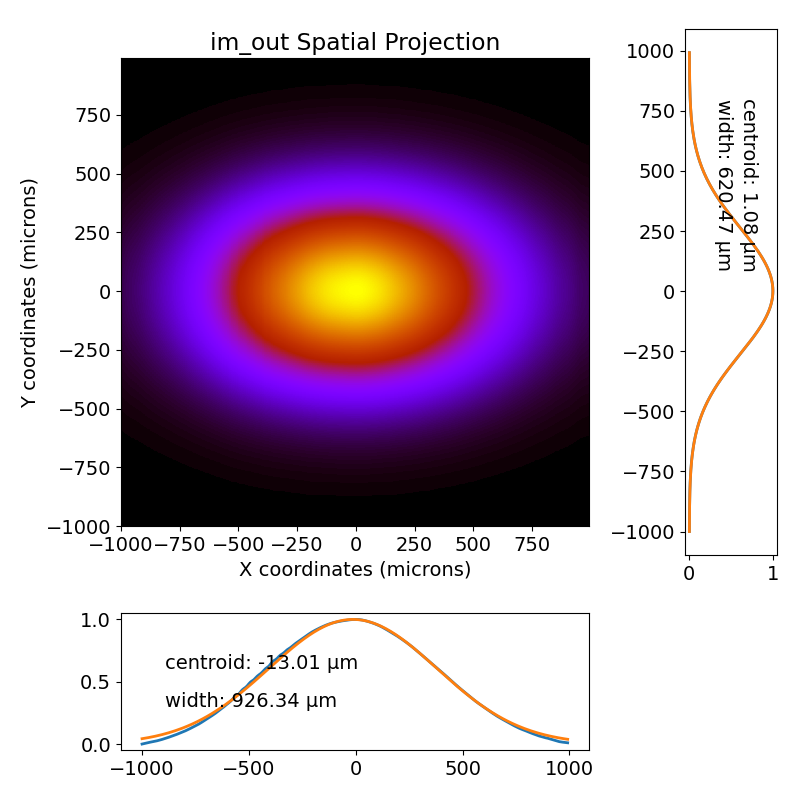

<IPython.core.display.Javascript object>


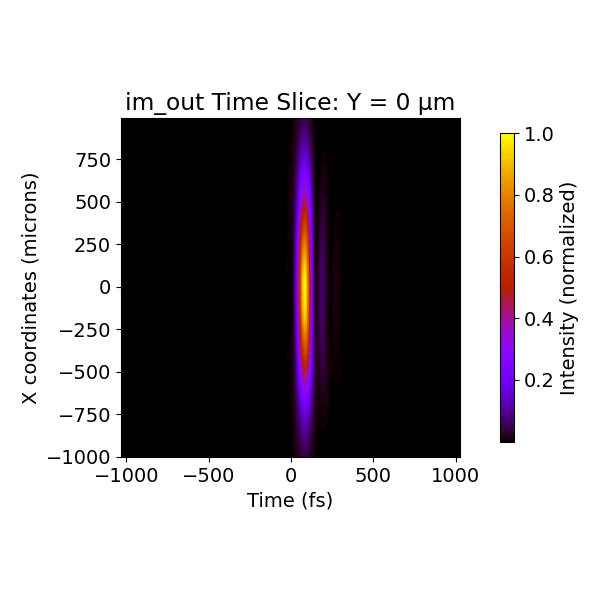

<IPython.core.display.Javascript object>


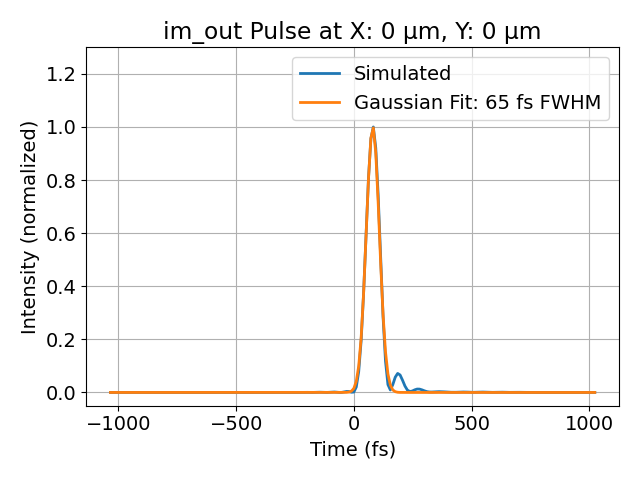

<IPython.core.display.Javascript object>


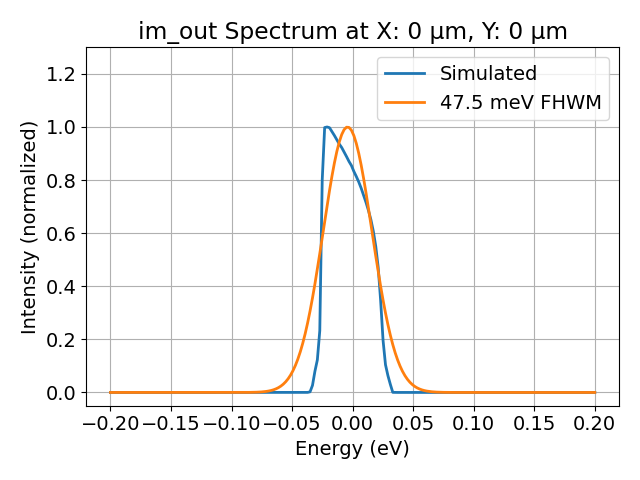

<IPython.core.display.Javascript object>


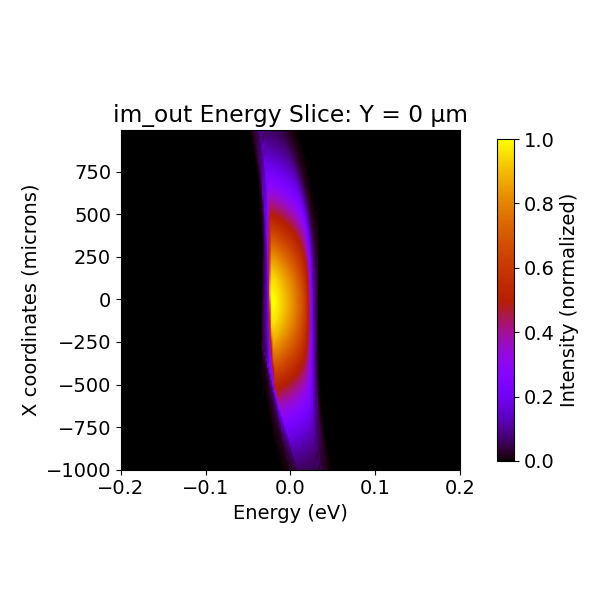

In [44]:
# pulse.plot_spectrum('im2')
pulse.imshow_projection('im_out')
pulse.imshow_time_slice('im_out')
pulse.plot_pulse('im_out')
pulse.plot_spectrum('im_out')
pulse.imshow_energy_slice('im_out')
plt.tight_layout()

# pulse.imshow_projection('focus')
# pulse.imshow_energy_slice('focus')

# pulse.imshow_projection('imc1')
# pulse.imshow_time_slice('imc1')
# pulse.imshow_time_slice('im3')
# pulse.imshow_energy_slice('im3')
# pulse.plot_pulse('im3')
# pulse.plot_spectrum('im3',show_fit=False)
# pulse.pulsefront_tilt('imc1')

## Slit closed

In [52]:
%%capture cap
N = 26

pulse_duration = np.zeros(N)
pulse_tilt = np.zeros(N)
spatial_chirp = np.zeros(N)
energy_bandwidth = np.zeros(N)
throughput = np.zeros(N)

m2_p = np.linspace(150,400,N)

E0 = 9481

for i in range(N):
    # reset central photon energy
    beam_params['photonEnergy'] = E0

    # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
    # pulse = beam.Pulse(beam_params=beam_params, tau=1000, time_window=100000)
    pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
    mono_beamline = define_beamline(E0,5e-6,m2_p=m2_p[i],shape=shapes[1]/2)
    
    pulse.propagate(beamline=mono_beamline,screen_names=['im0','im_out'])
    c, pulse_duration[i] = pulse.pulse_duration('im_out')
    pulse_tilt[i] = pulse.pulsefront_tilt('im_out')
    spatial_chirp[i] = pulse.spatial_chirp('im_out')
    energy_bandwidth[i] = pulse.pulse_bandwidth('im_out')
    throughput[i] = pulse.throughput('im0','im_out')

In [53]:
%%capture cap
N = 26

pulse_duration0 = np.zeros(N)
pulse_tilt0 = np.zeros(N)
spatial_chirp0 = np.zeros(N)
energy_bandwidth0 = np.zeros(N)
throughput0 = np.zeros(N)

m2_p = np.linspace(150,400,N)

E0 = 9481

for i in range(N):
    # reset central photon energy
    beam_params['photonEnergy'] = E0

    # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
    # pulse = beam.Pulse(beam_params=beam_params, tau=1000, time_window=100000)
    pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
    mono_beamline = define_beamline(E0,5e-6,m2_p=m2_p[i])
    
    pulse.propagate(beamline=mono_beamline,screen_names=['im0','im_out'])
    c, pulse_duration0[i] = pulse.pulse_duration('im_out')
    pulse_tilt0[i] = pulse.pulsefront_tilt('im_out')
    spatial_chirp0[i] = pulse.spatial_chirp('im_out')
    energy_bandwidth0[i] = pulse.pulse_bandwidth('im_out')
    throughput0[i] = pulse.throughput('im0','im_out')

<IPython.core.display.Javascript object>


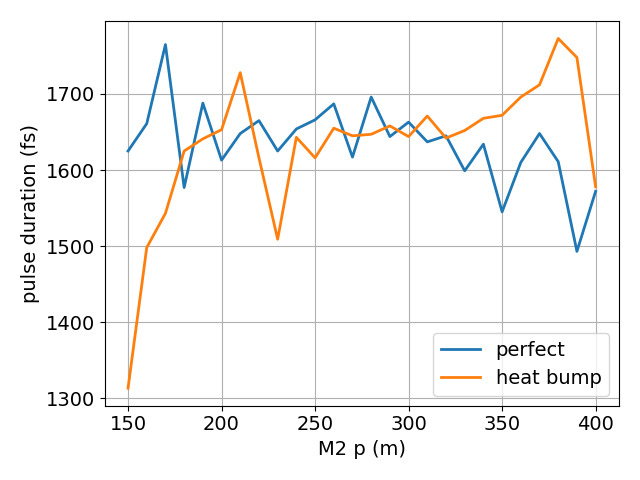

<IPython.core.display.Javascript object>


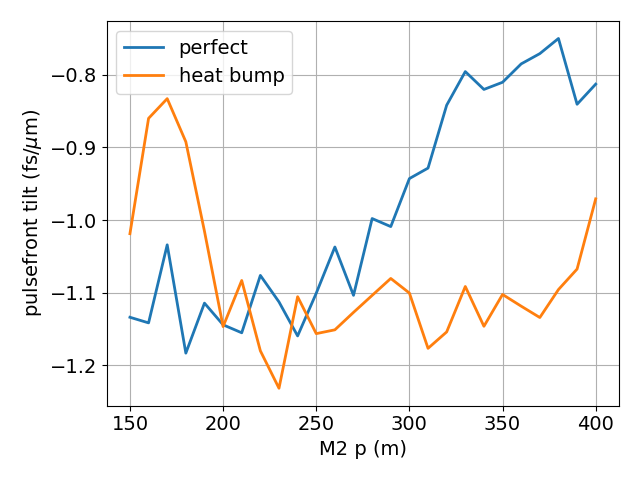

<IPython.core.display.Javascript object>


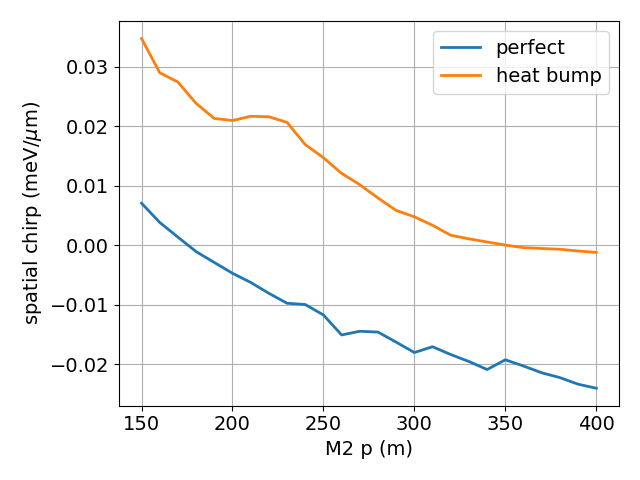

<IPython.core.display.Javascript object>


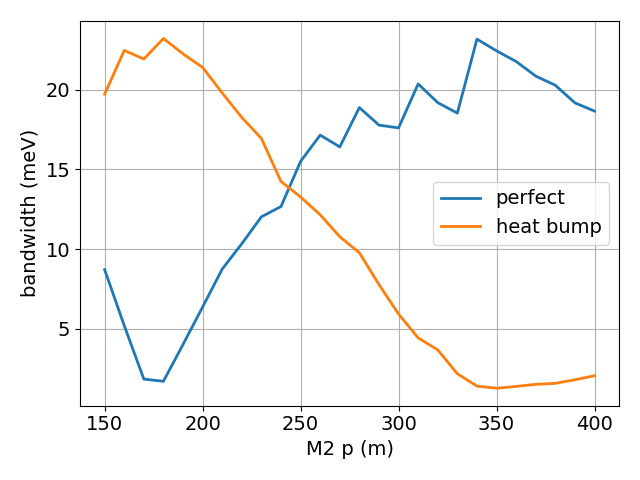

<IPython.core.display.Javascript object>


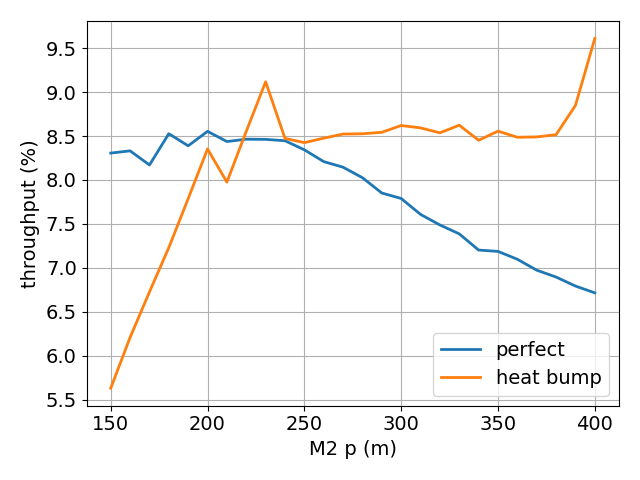

In [54]:
plt.figure()
plt.plot(m2_p, pulse_duration0,label='perfect')
plt.plot(m2_p, pulse_duration,label='heat bump')
plt.xlabel('M2 p (m)')
plt.ylabel('pulse duration (fs)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot(m2_p, pulse_tilt0,label='perfect')
plt.plot(m2_p, pulse_tilt,label='heat bump')
plt.xlabel('M2 p (m)')
plt.ylabel(r'pulsefront tilt (fs/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot(m2_p, spatial_chirp0*1000,label='perfect')
plt.plot(m2_p, spatial_chirp*1000,label='heat bump')
plt.xlabel('M2 p (m)')
plt.ylabel(r'spatial chirp (meV/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot(m2_p, energy_bandwidth0*1000,label='perfect')
plt.plot(m2_p, energy_bandwidth*1000,label='heat bump')
plt.xlabel('M2 p (m)')
plt.ylabel('bandwidth (meV)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot(m2_p, throughput0*100,label='perfect')
plt.plot(m2_p, throughput*100,label='heat bump')
plt.xlabel('M2 p (m)')
plt.ylabel('throughput (%)')
plt.grid()
plt.legend()
plt.tight_layout()

In [43]:
%%capture cap
E0 = 9481
# reset central photon energy
beam_params['photonEnergy'] = E0

# initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
# pulse = beam.Pulse(beam_params=beam_params, tau=1000, time_window=100000)
pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
mono_beamline = define_beamline(E0,5e-6)

pulse.propagate(beamline=mono_beamline,screen_names=['im_out'])

<IPython.core.display.Javascript object>


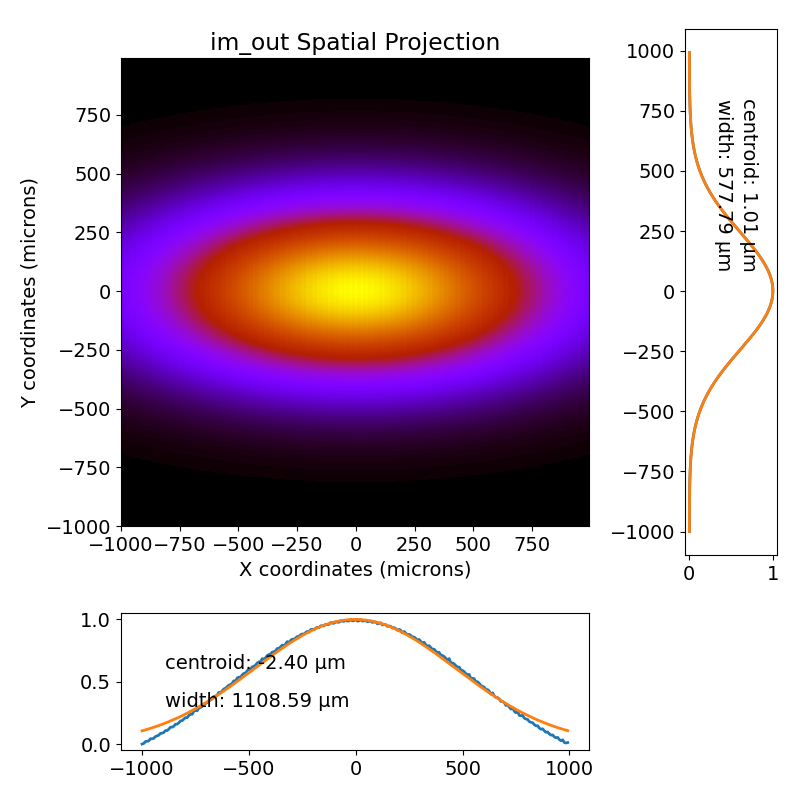

<IPython.core.display.Javascript object>


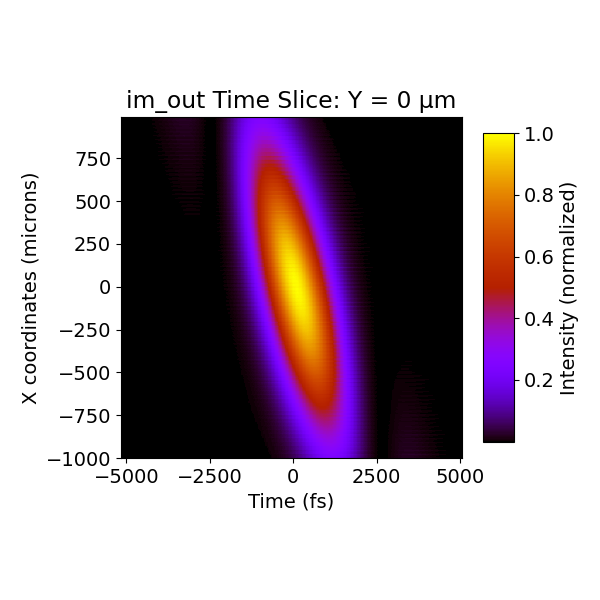

<IPython.core.display.Javascript object>


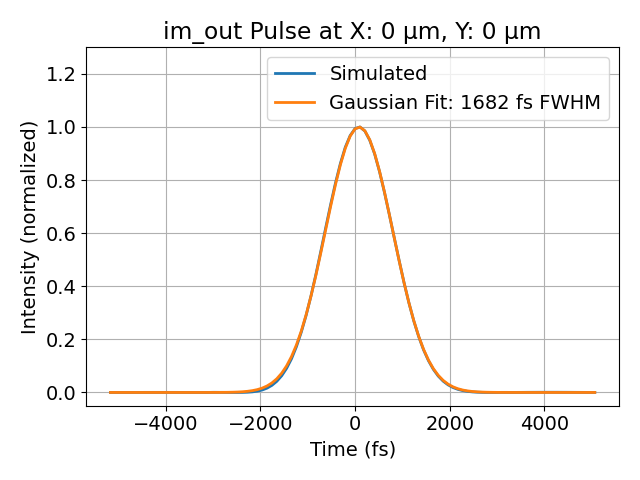

<IPython.core.display.Javascript object>


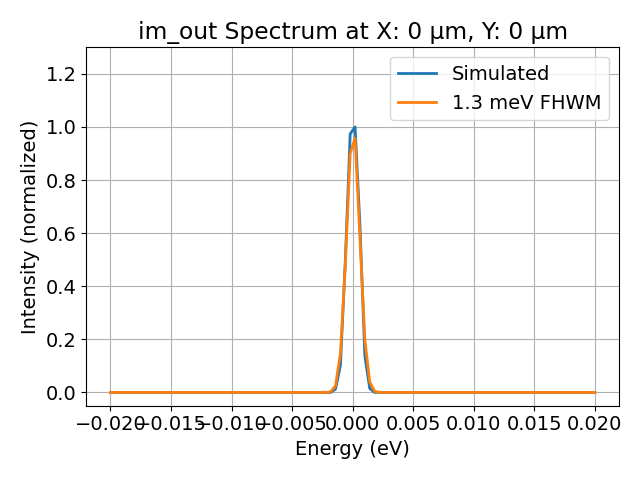

<IPython.core.display.Javascript object>


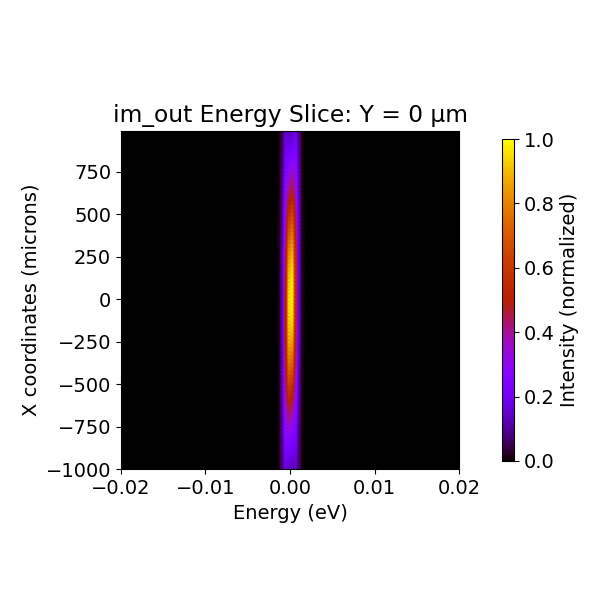

In [44]:
# pulse.plot_spectrum('im2')
pulse.imshow_projection('im_out')
pulse.imshow_time_slice('im_out')
pulse.plot_pulse('im_out')
pulse.plot_spectrum('im_out')
pulse.imshow_energy_slice('im_out')
plt.tight_layout()

# pulse.imshow_projection('focus')
# pulse.imshow_energy_slice('focus')

# pulse.imshow_projection('imc1')
# pulse.imshow_time_slice('imc1')
# pulse.imshow_time_slice('im3')
# pulse.imshow_energy_slice('im3')
# pulse.plot_pulse('im3')
# pulse.plot_spectrum('im3',show_fit=False)
# pulse.pulsefront_tilt('imc1')

In [71]:
%%capture cap
E0 = 9481
# reset central photon energy
beam_params['photonEnergy'] = E0

# initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
# pulse = beam.Pulse(beam_params=beam_params, tau=1000, time_window=100000)
pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
mono_beamline = define_beamline(E0,5e-6,m2_p=280,shape=shapes[1]/10)

pulse.propagate(beamline=mono_beamline,screen_names=['im_out'])

<IPython.core.display.Javascript object>


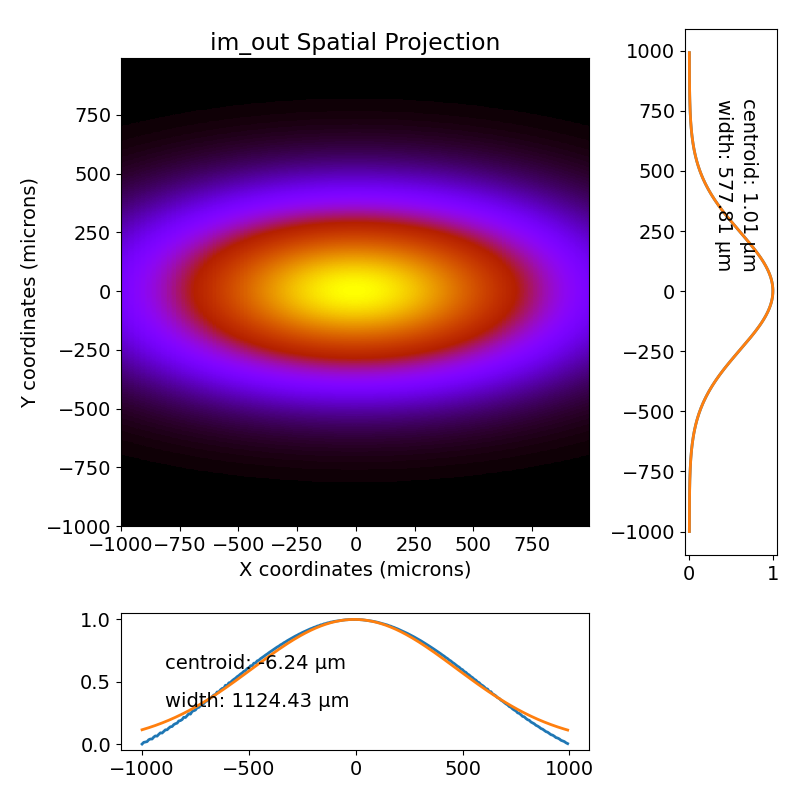

<IPython.core.display.Javascript object>


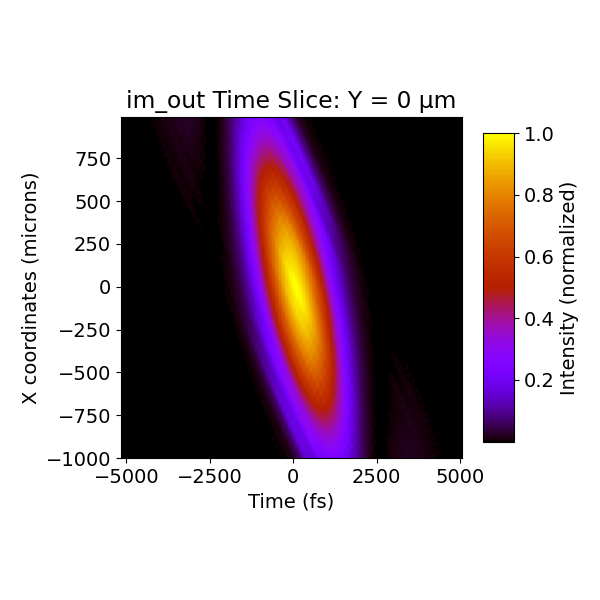

<IPython.core.display.Javascript object>


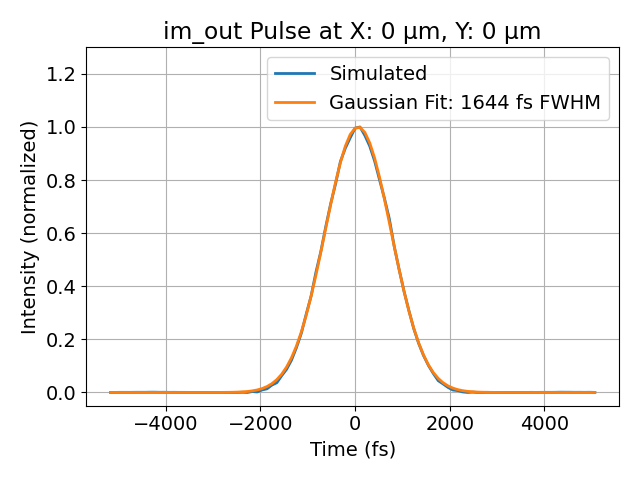

<IPython.core.display.Javascript object>


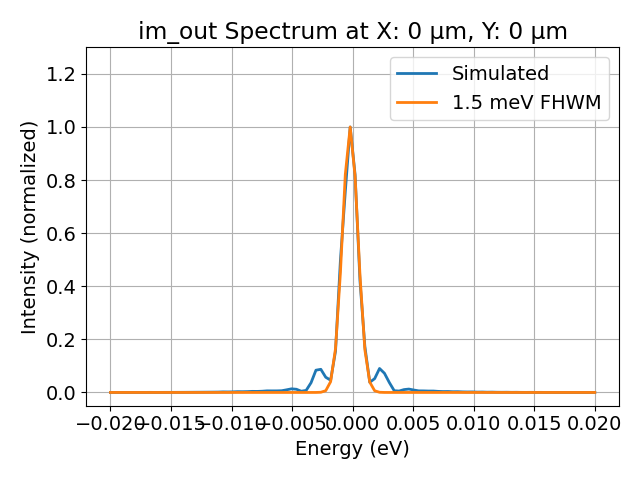

<IPython.core.display.Javascript object>


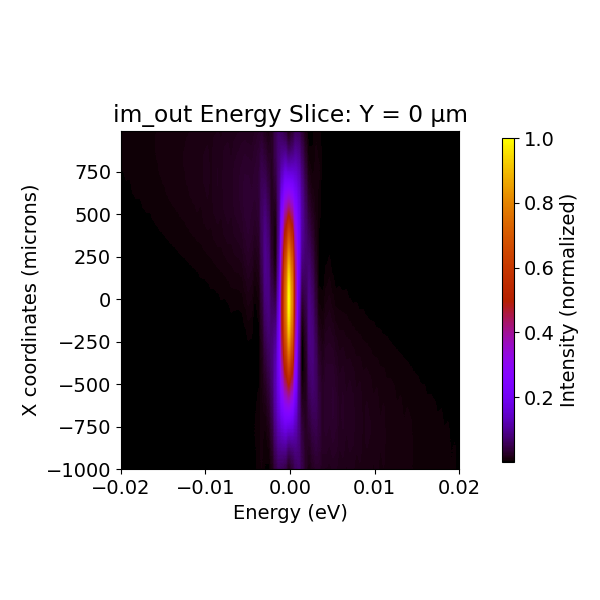

In [72]:
# pulse.plot_spectrum('im2')
pulse.imshow_projection('im_out')
pulse.imshow_time_slice('im_out')
pulse.plot_pulse('im_out')
pulse.plot_spectrum('im_out')
pulse.imshow_energy_slice('im_out')
plt.tight_layout()

# pulse.imshow_projection('focus')
# pulse.imshow_energy_slice('focus')

# pulse.imshow_projection('imc1')
# pulse.imshow_time_slice('imc1')
# pulse.imshow_time_slice('im3')
# pulse.imshow_energy_slice('im3')
# pulse.plot_pulse('im3')
# pulse.plot_spectrum('im3',show_fit=False)
# pulse.pulsefront_tilt('imc1')

In [5]:
%%capture cap

bandwidth = np.zeros(20)
width1 = np.zeros(20)

L_c = np.linspace(-2,2,20)

for i in range(20):
    beam_params['photonEnergy'] = 9481
    mono_beamline = define_beamline(L_c[i])
    pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=1000)
    pulse.propagate(beamline=mono_beamline, screen_names=['im2','im_c2'])
    try:
        width1[i] = pulse.pulse_duration('im2')[1]
    except:
        width1[i] = 0
    try:
        bandwidth[i] = pulse.pulse_bandwidth('im2')
    except:
        bandwidth[i] = 0
    

In [6]:
SRW_data = np.load('4f_SRW_test.npz')
SRW_dL = SRW_data['dL']
SRW_width = SRW_data['width']

In [8]:
def image_distance(dL):
    L = 10-dL
    f = 10
    i1 = L*f/(L-f)
    o2 = 2*f-i1
    i2 = o2*f/(o2-f)
    Delta = i2-L
    return Delta

0.9293670404464403
1.9496099867975202e-10
76.5650197385478


<IPython.core.display.Javascript object>


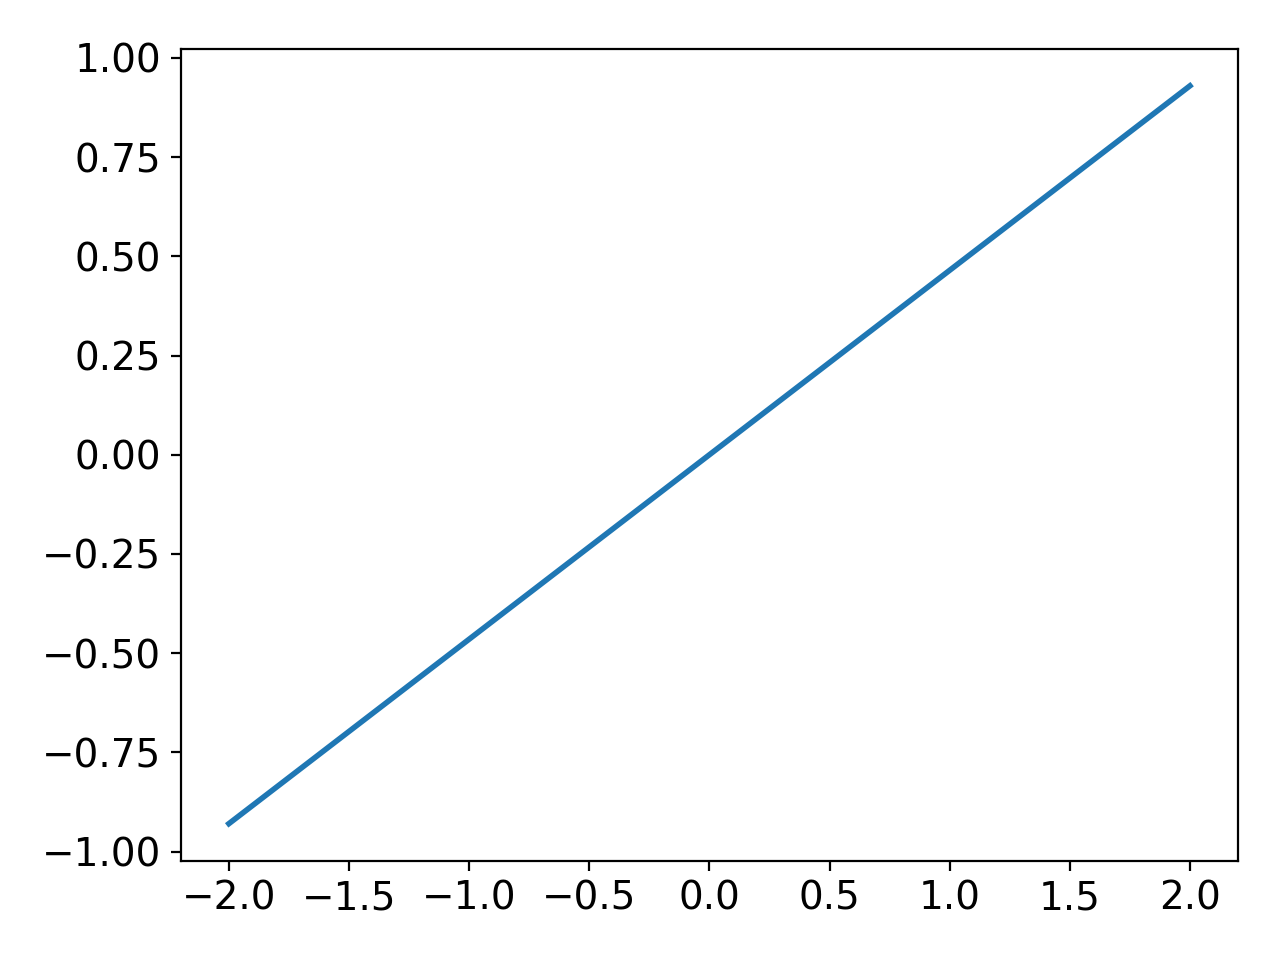

<IPython.core.display.Javascript object>


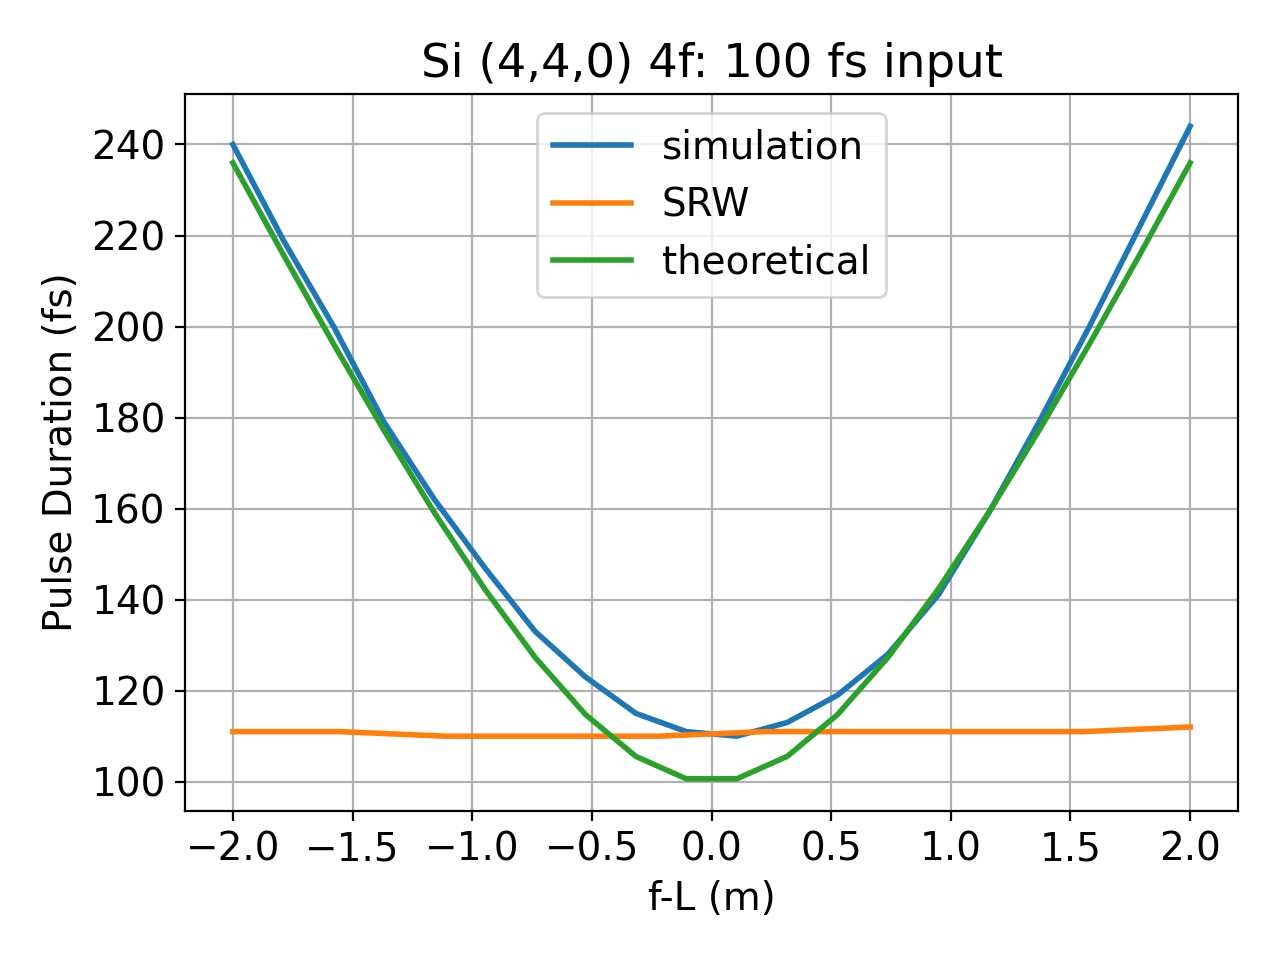

7708.680360651277


In [12]:
D = image_distance(L_c)*np.sin(mono_beamline.c2.beta0)
print(np.max(D))

alphaAsym = 29.5*np.pi/180
E = 9481
alpha0 = mono_beamline.c1.alpha
Lambda = 1/(np.sin(alphaAsym)/mono_beamline.c2.d)
print(Lambda)
lambda0 = 1239.8/E*1e-9
beta0 = mono_beamline.c2.beta0
print((np.pi/2-beta0)*180/np.pi)

# GDD = -(lambda0**3*L_c*2)/(2*np.pi*(3e8)**2*Lambda**2)*(1-((lambda0/Lambda+np.sin(np.pi/2-alpha0)))**2)**(-3/2)*(1e15)**2
GDD = -(lambda0**3*D)/(2*np.pi*(3e8)**2*Lambda**2)*(1e15)**2/np.cos(np.pi/2-beta0)**3

plt.figure()
plt.plot(L_c,D)

plt.figure()
plt.plot(L_c,width1,label='simulation')
plt.plot(SRW_dL,SRW_width,label='SRW')
plt.plot(L_c,np.sqrt(100**4 + 16*np.log(2)**2*(GDD)**2)/100,label='theoretical')
plt.legend()
plt.grid()
plt.xlabel('f-L (m)')
plt.ylabel('Pulse Duration (fs)')
plt.title('Si (4,4,0) 4f: 100 fs input')

print(np.max(GDD))

In [46]:
%%capture capt

beam_params['photonEnergy'] = 9481
mono_beamline = define_beamline(0)
pulse = beam.Pulse(beam_params=beam_params, tau=30, time_window=1000)
pulse.propagate(beamline=mono_beamline, screen_names=['im0','im2','im_c2'])

<IPython.core.display.Javascript object>


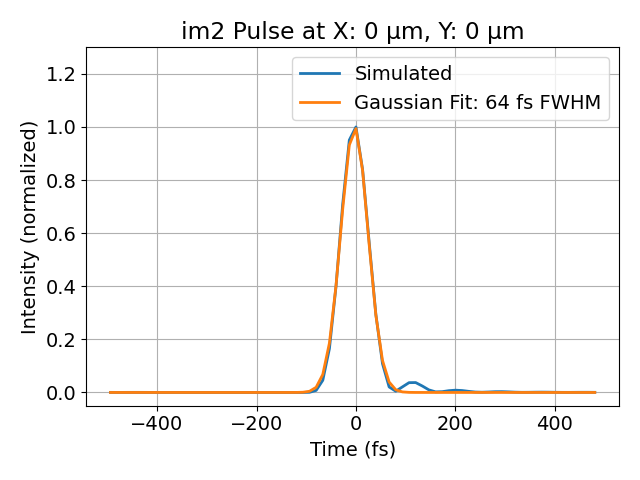

<IPython.core.display.Javascript object>


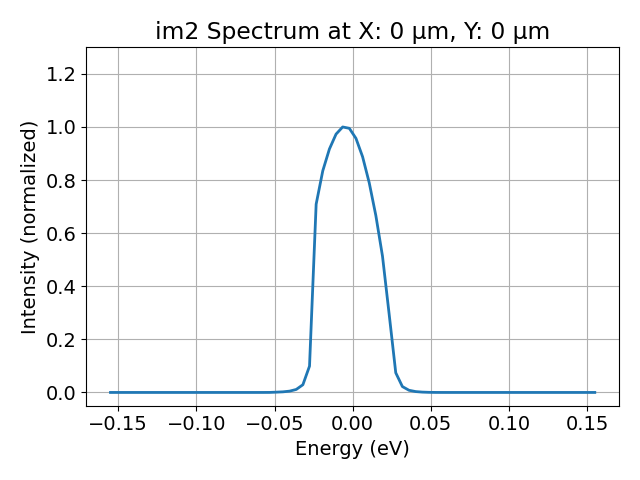

<IPython.core.display.Javascript object>


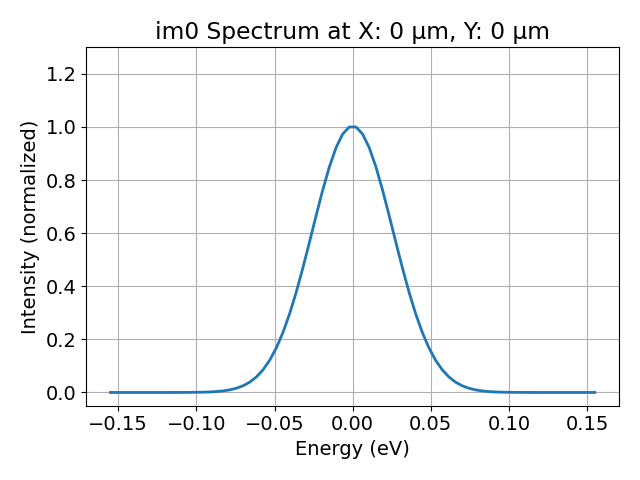

/Users/seaberg/beamline/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


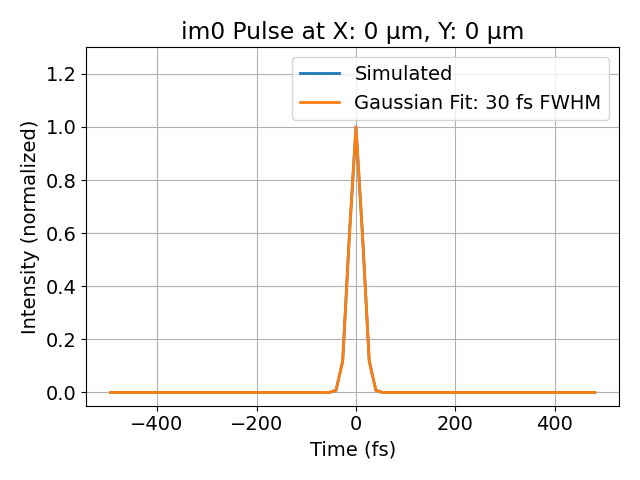

In [52]:
pulse.plot_pulse('im2',shift=-100)
pulse.plot_spectrum('im2',show_fit=False)
pulse.plot_spectrum('im0',show_fit=False)
pulse.plot_pulse('im0')

<IPython.core.display.Javascript object>


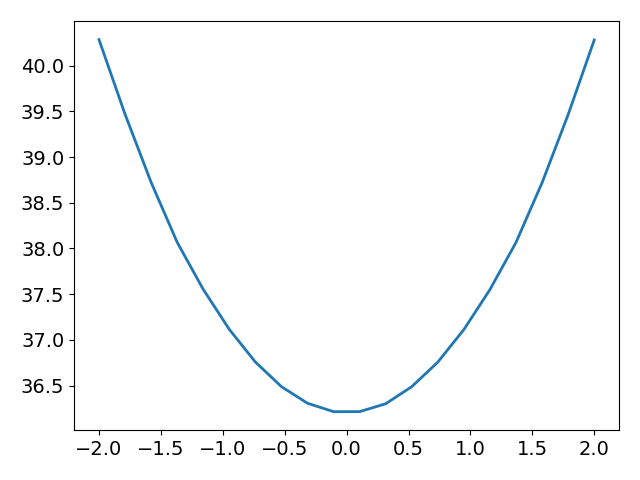

In [15]:
plt.figure()
plt.plot(L_c,1.8/bandwidth)

-323.3333333333326
10.3
0.6000000000000014


<IPython.core.display.Javascript object>


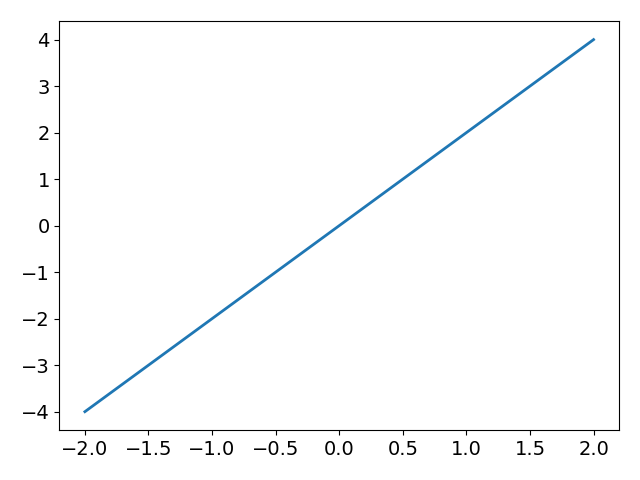

In [4]:
L = 9.7
f = 10
i1 = L*f/(L-f)
print(i1)
o2 = 2*f-i1
i2 = o2*f/(o2-f)
print(i2)
Delta = i2-L
print(Delta)

def image_distance(dL):
    L = 10-dL
    f = 10
    i1 = L*f/(L-f)
    o2 = 2*f-i1
    i2 = o2*f/(o2-f)
    Delta = i2-L
    return Delta

L_c = np.linspace(-2,2,20)

plt.figure()
plt.plot(L_c,image_distance(L_c))

<IPython.core.display.Javascript object>


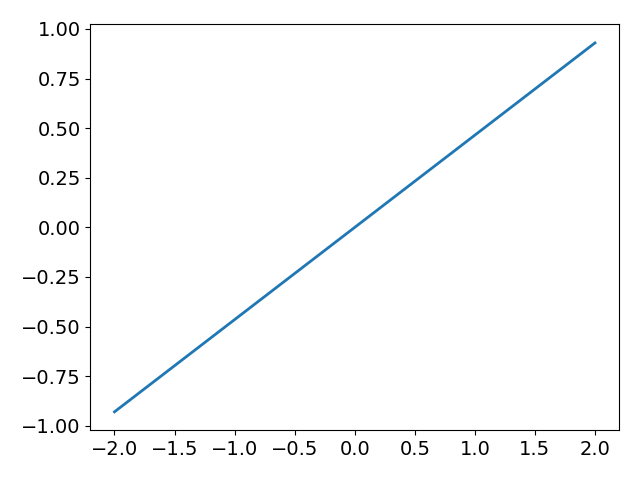

<IPython.core.display.Javascript object>


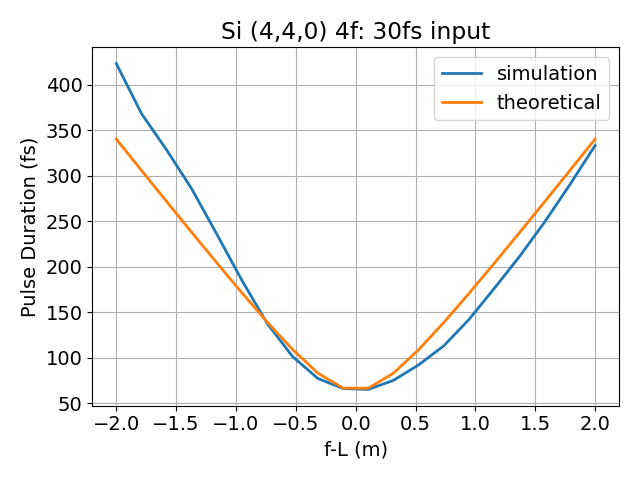

Text(0.5, 1.0, 'Si (4,4,0) 4f: 30fs input')

In [45]:
D = image_distance(L_c)*np.sin(mono_beamline.c2.beta0)
# D = 2*L_c*np.sin(mono_beamline.c2.beta0)

alphaAsym = 29.5*np.pi/180
E = 9481
alpha0 = mono_beamline.c1.alpha
Lambda = 1/(np.sin(alphaAsym)/mono_beamline.c2.d)
lambda0 = 1239.8/E*1e-9
beta0 = mono_beamline.c2.beta0

# GDD = -(lambda0**3*L_c*2)/(2*np.pi*(3e8)**2*Lambda**2)*(1-((lambda0/Lambda+np.sin(np.pi/2-alpha0)))**2)**(-3/2)*(1e15)**2
GDD = -(lambda0**3*D)/(2*np.pi*(3e8)**2*Lambda**2)*(1e15)**2/np.cos(np.pi/2-beta0)**3

plt.figure()
plt.plot(L_c,D)

plt.figure()
plt.plot(L_c,width1,label='simulation')
plt.plot(L_c,np.sqrt(64**4 + 16*np.log(2)**2*(GDD)**2)/64,label='theoretical')
plt.legend()
plt.grid()
plt.xlabel('f-L (m)')
plt.ylabel('Pulse Duration (fs)')
plt.title('Si (4,4,0) 4f: 30fs input')

In [16]:
%%capture cap

beam_params['photonEnergy'] = 9481
mono_beamline = define_beamline(0)
pulse = beam.Pulse(beam_params=beam_params, tau=30, time_window=1000)
time0 = time.time()
# propagate pulse through beamline. This will take a minute or so (depends on number of spectral 
# components which is proportional to the ratio time_window/tau).
pulse.propagate(beamline=mono_beamline, screen_names=['im0','focus','im2','im_c2'])
time1 = time.time()
delta_t = time1-time0

In [17]:
print(delta_t)

6.89067006111145


### Visualize output

<IPython.core.display.Javascript object>


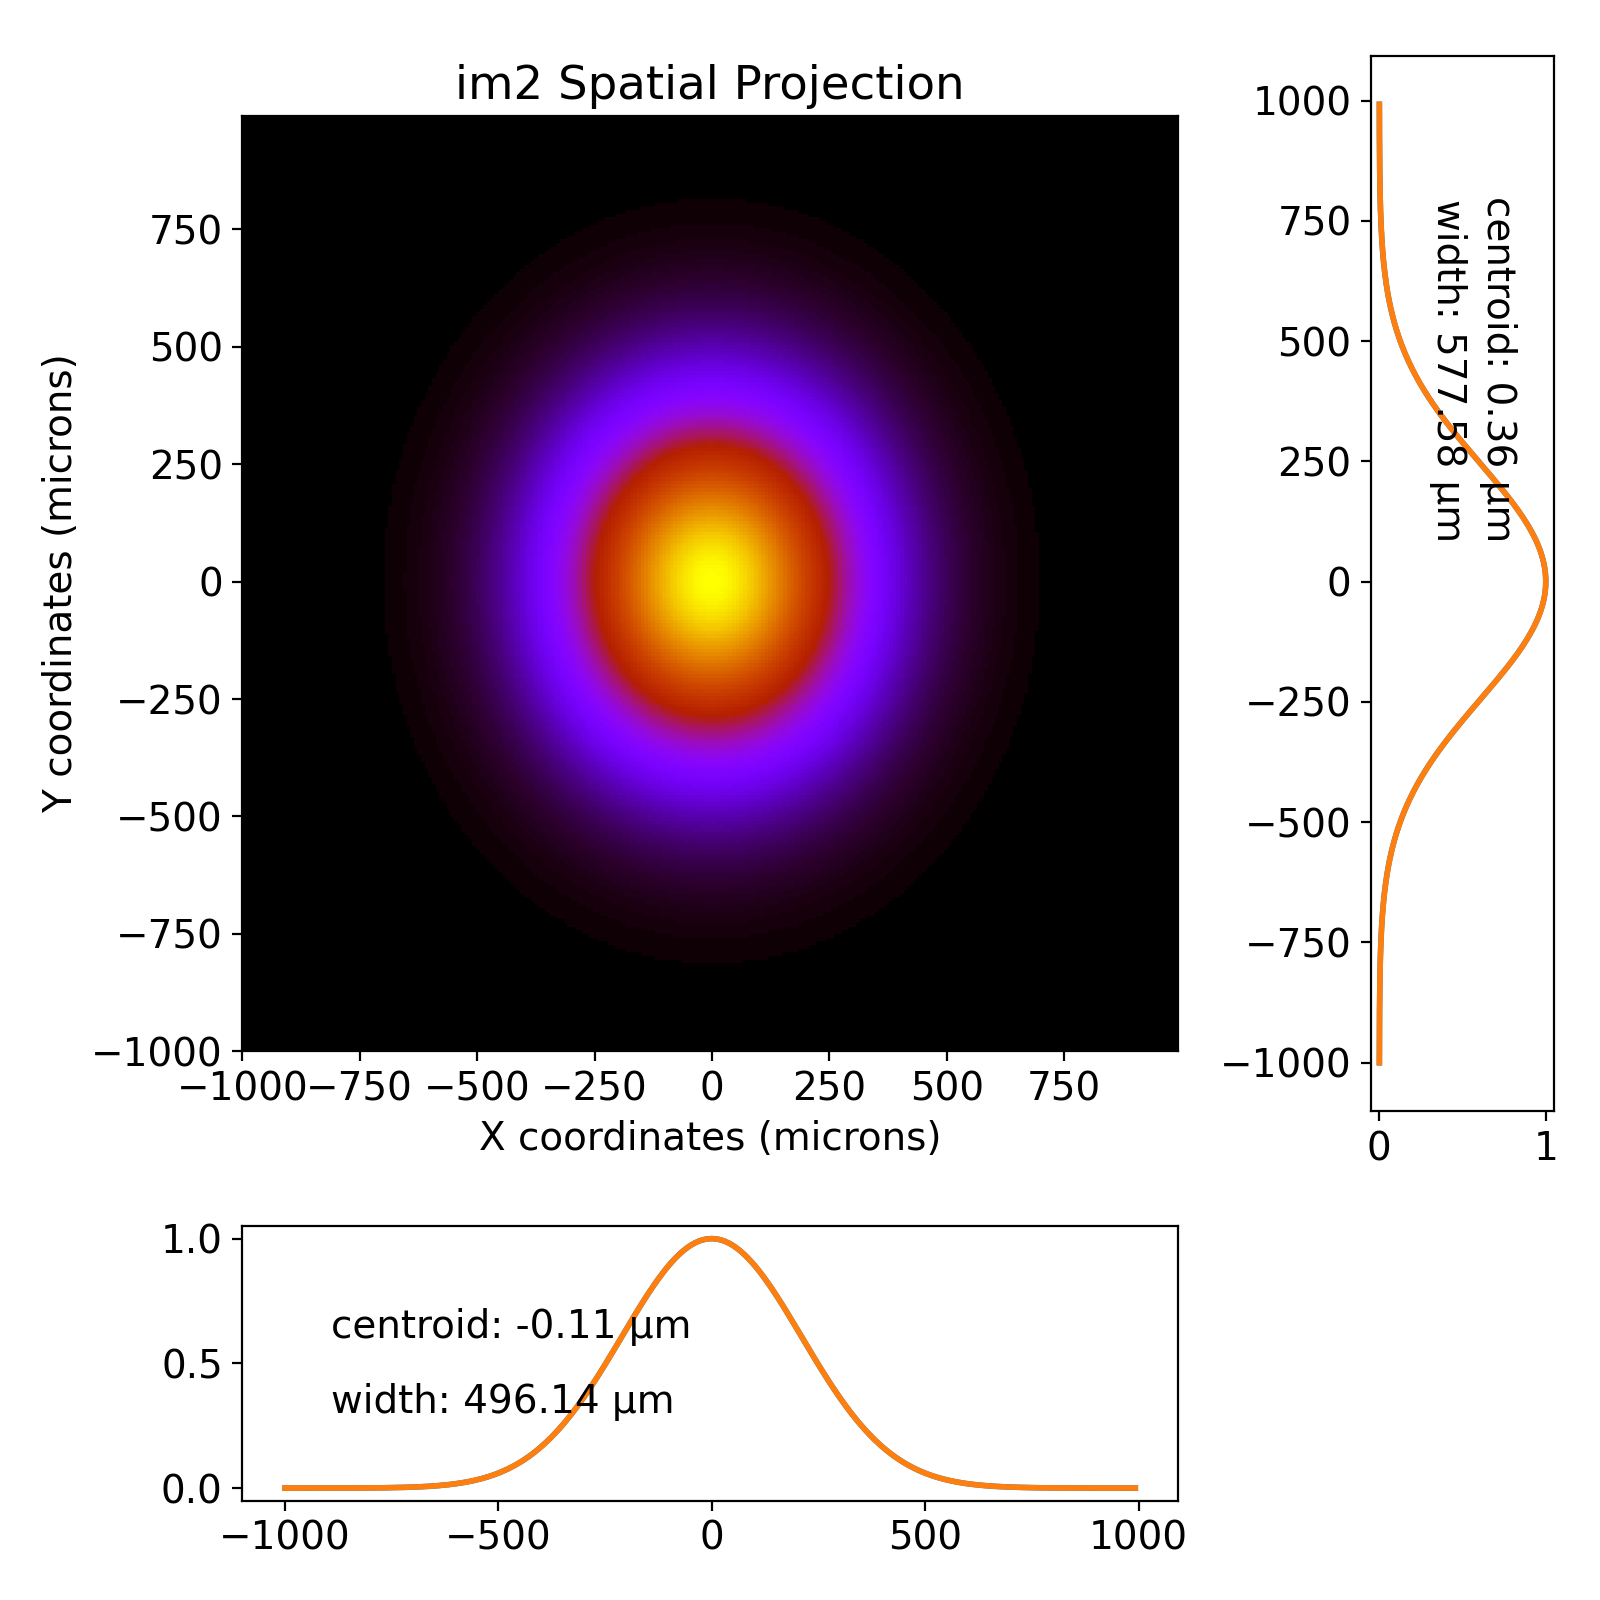

/Users/seaberg/beamline/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


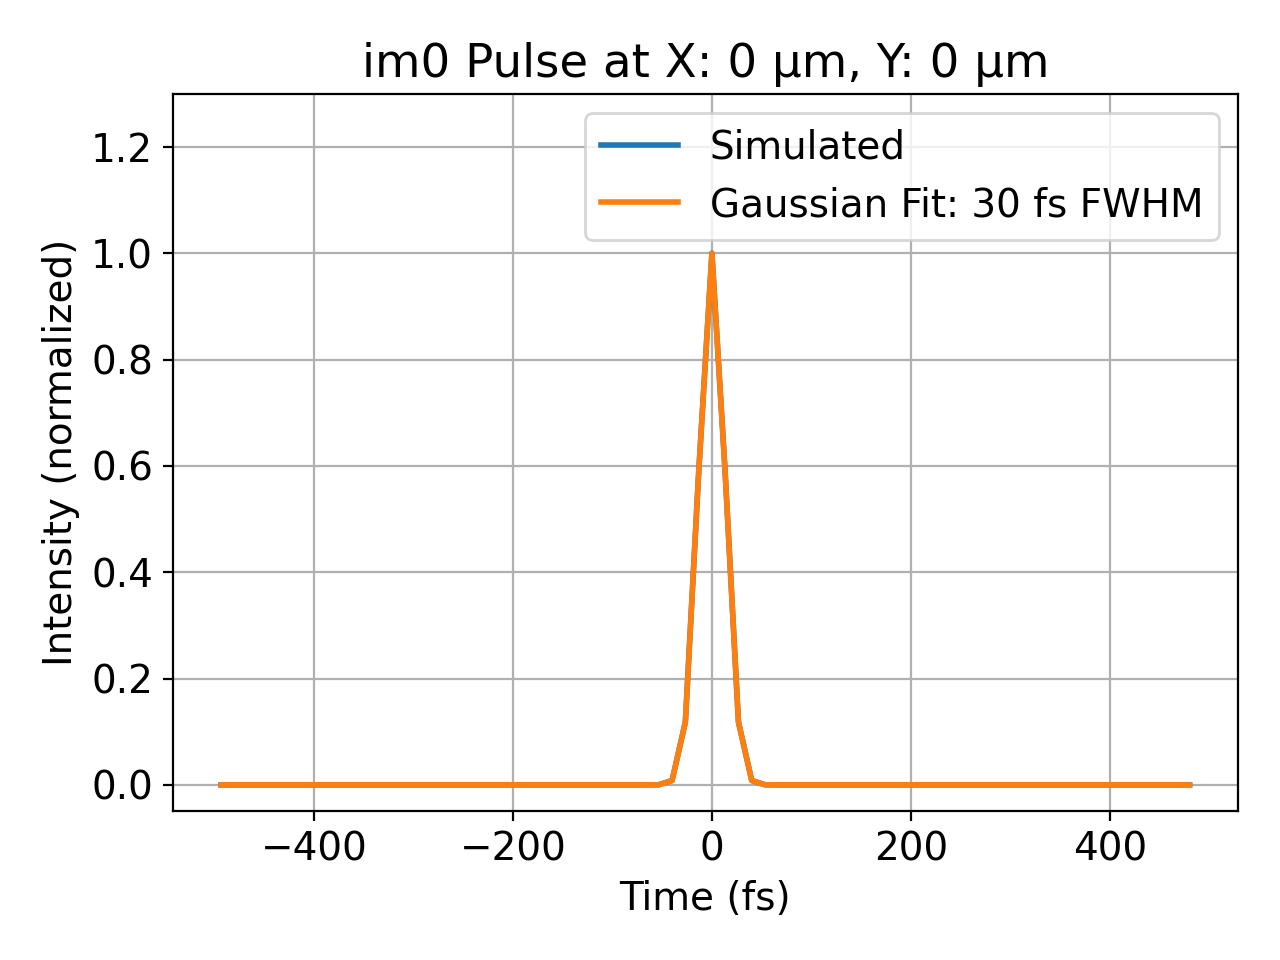

<IPython.core.display.Javascript object>


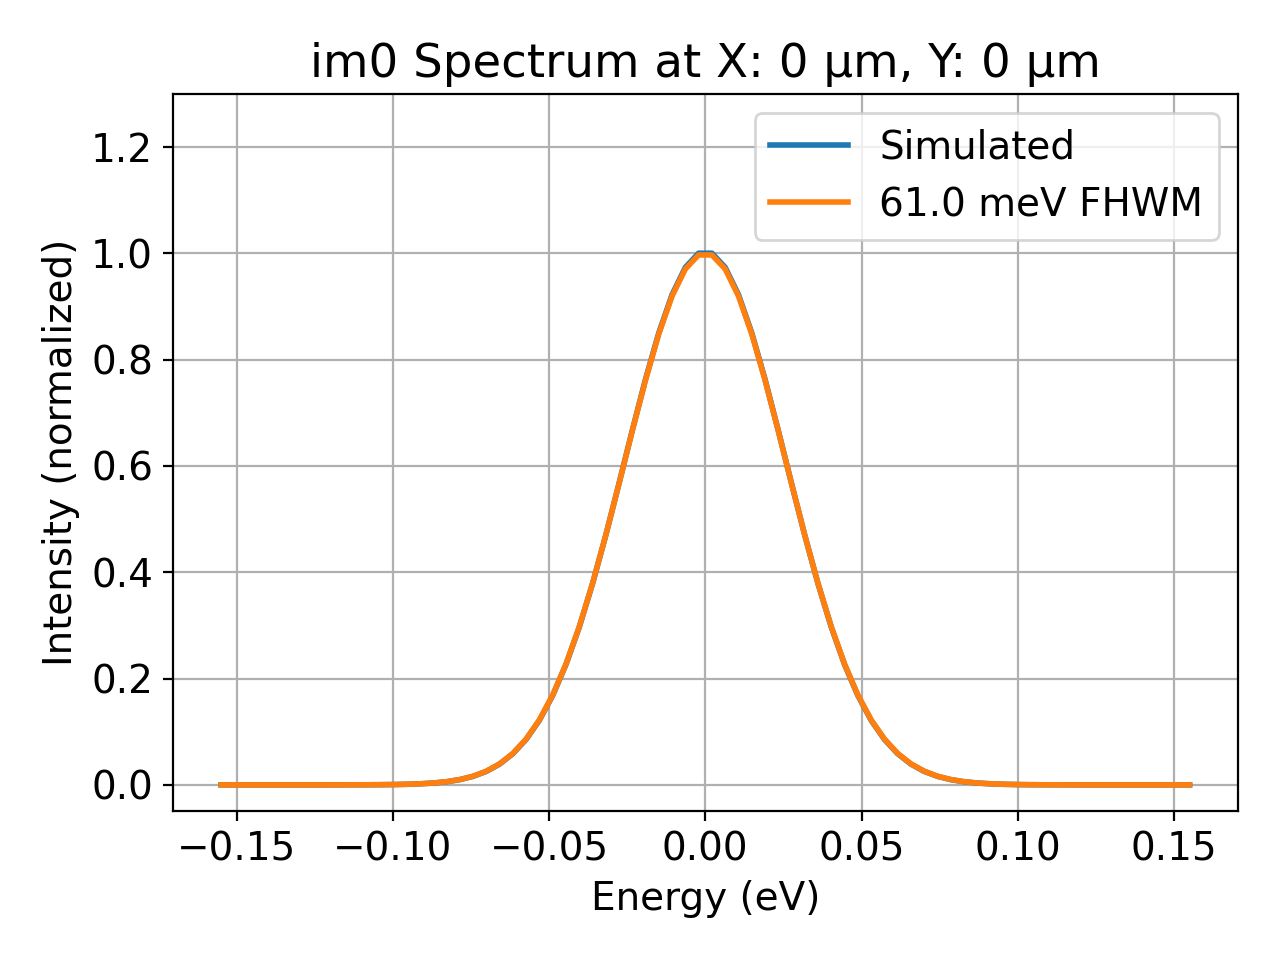

<IPython.core.display.Javascript object>


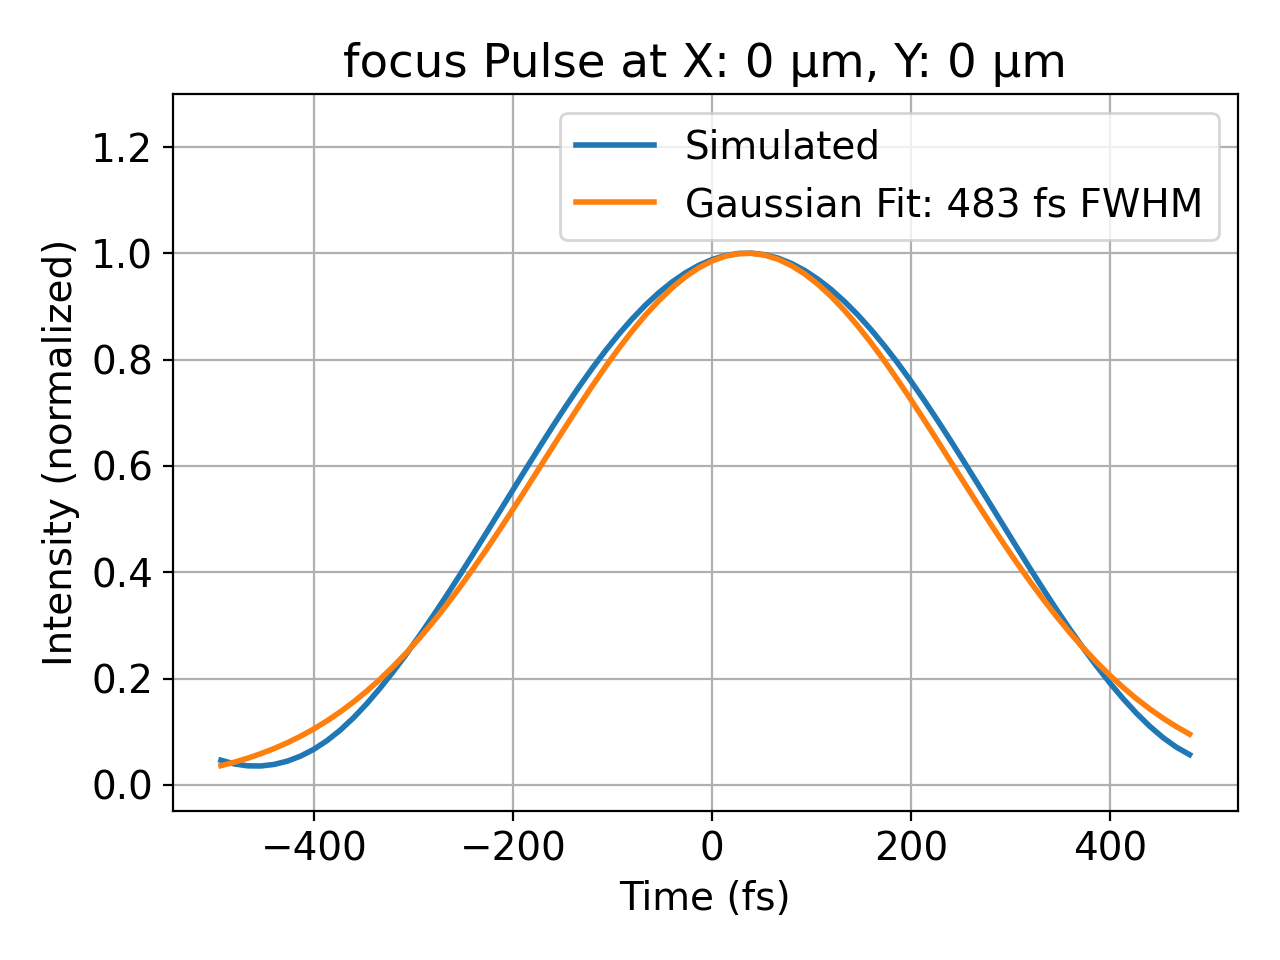

<IPython.core.display.Javascript object>


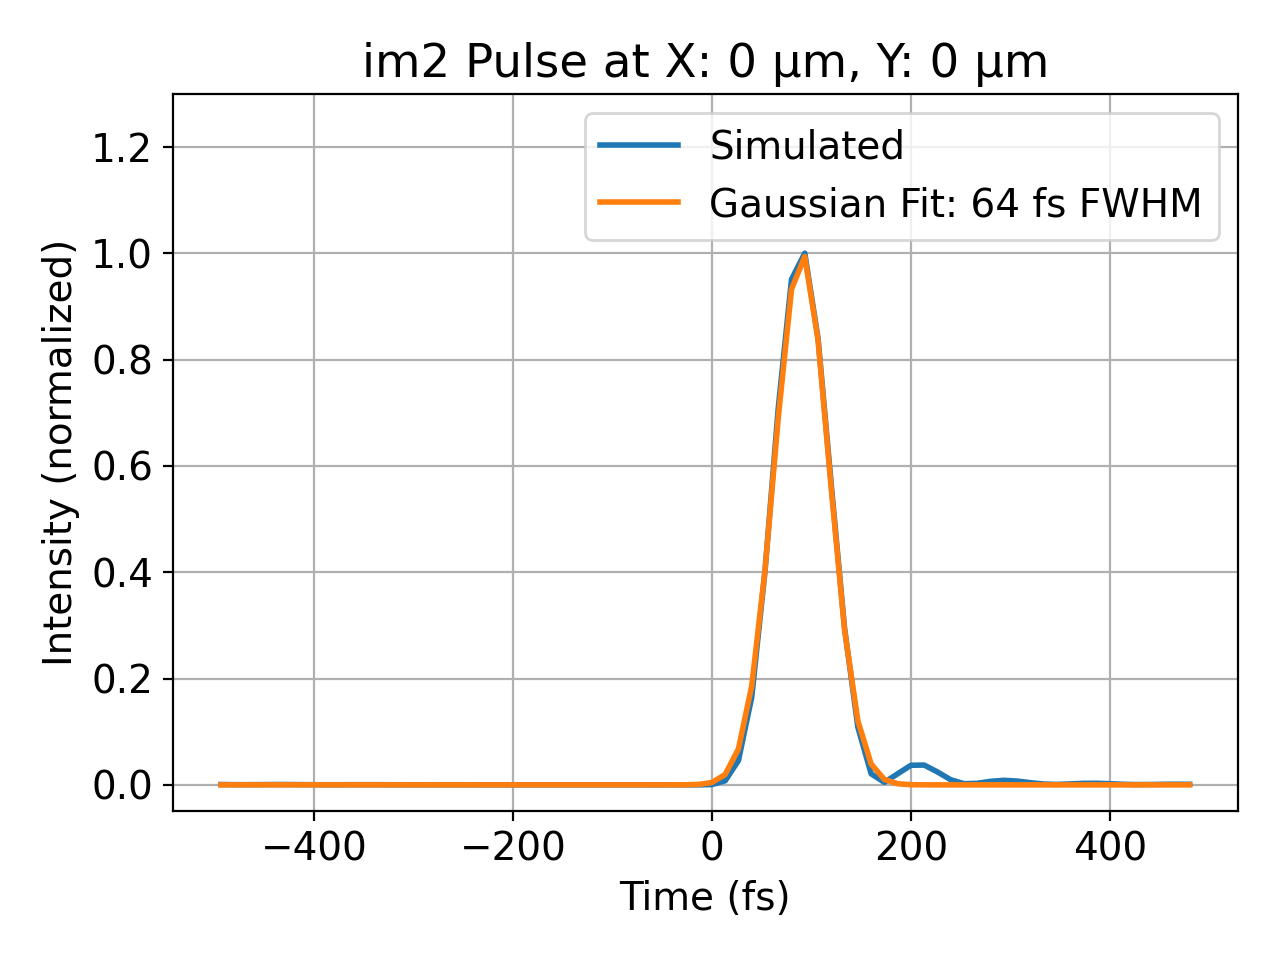

<IPython.core.display.Javascript object>


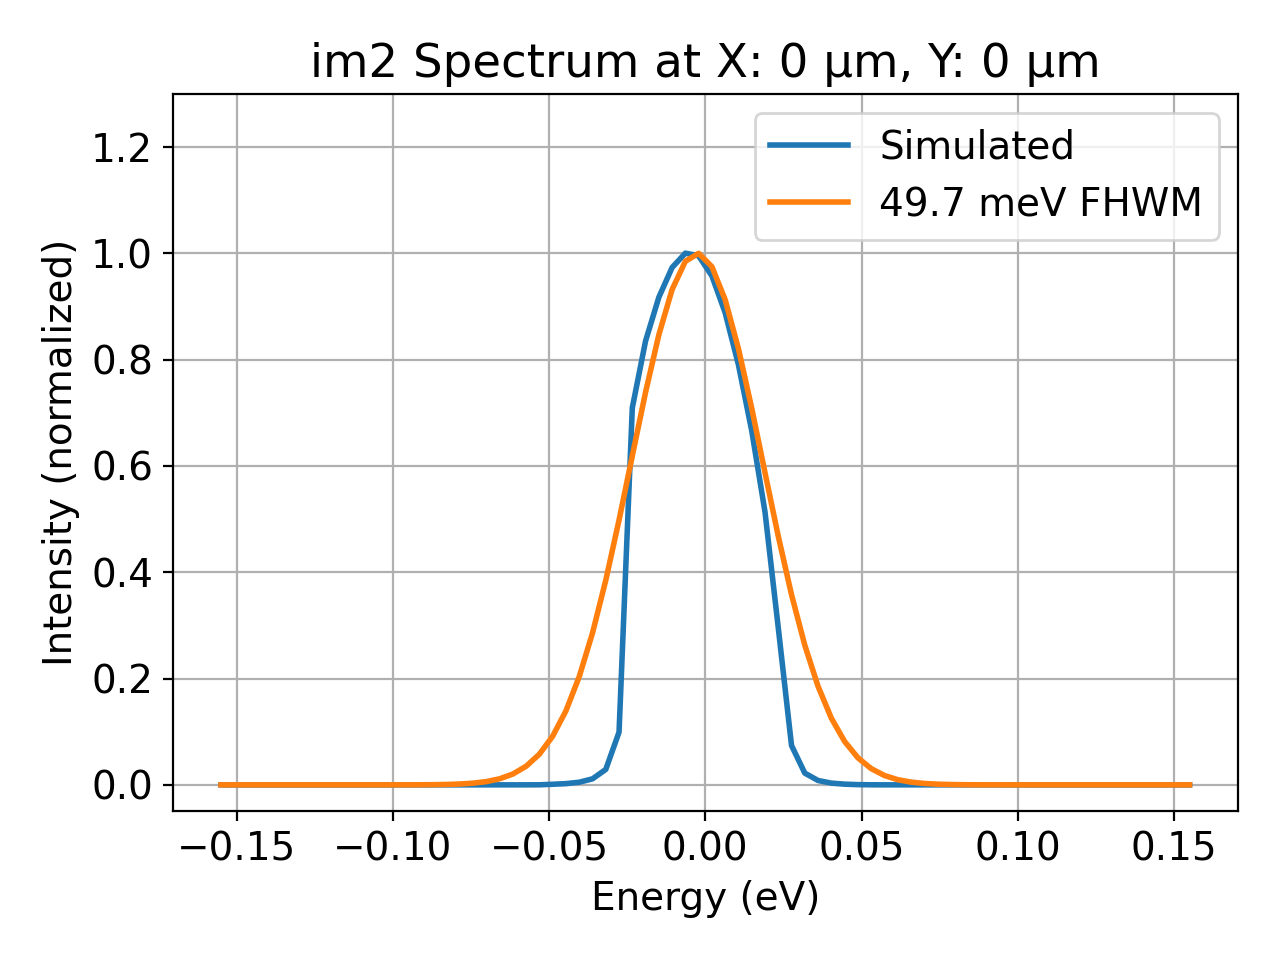

<IPython.core.display.Javascript object>


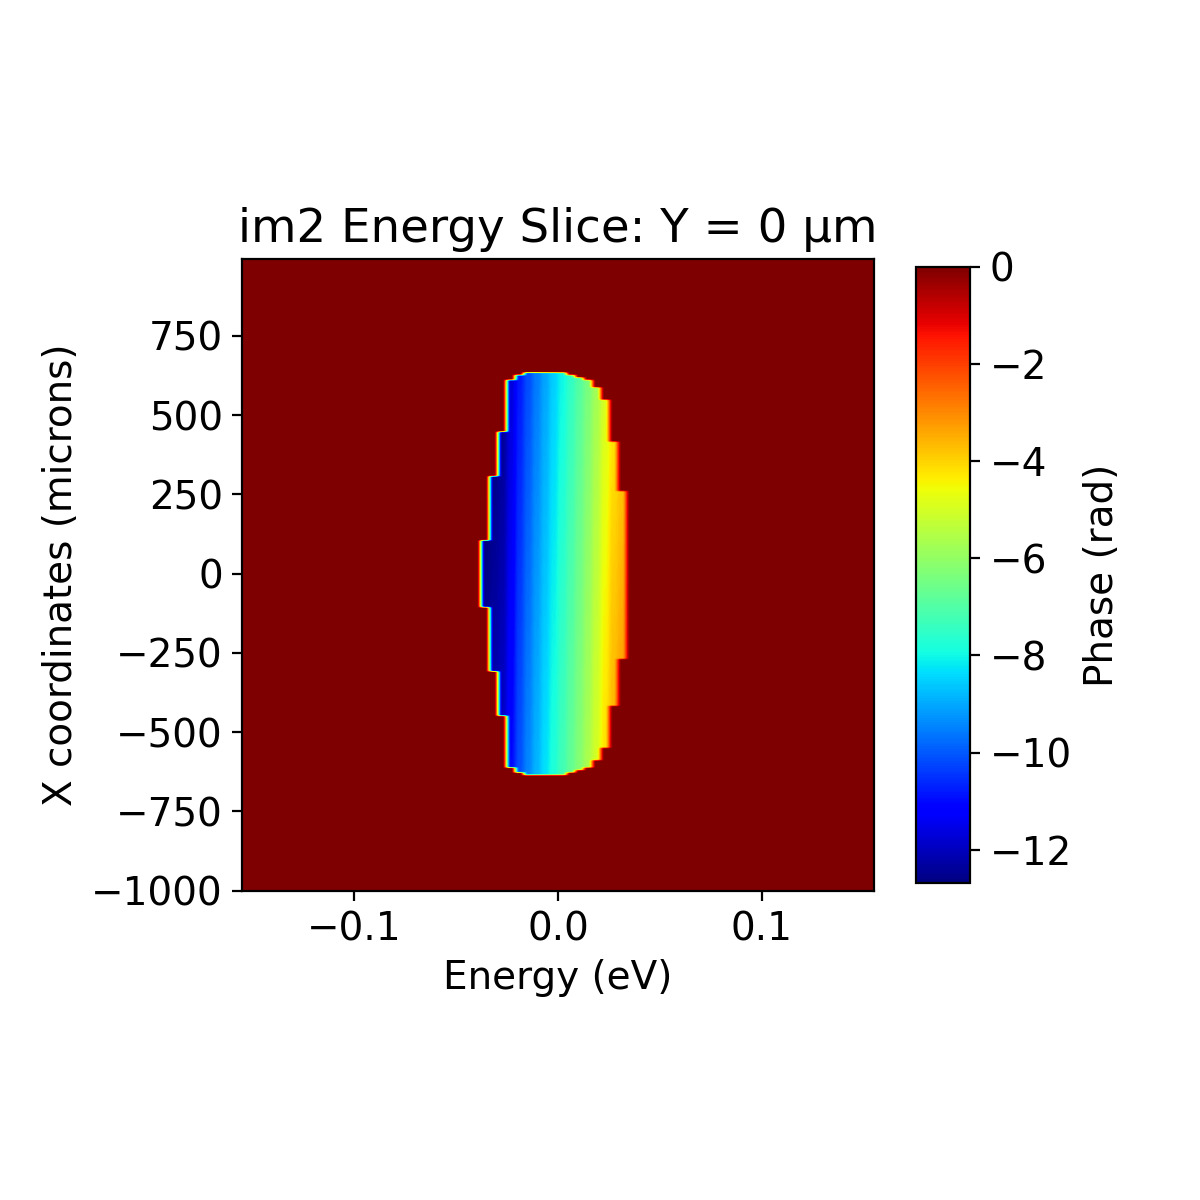

<IPython.core.display.Javascript object>


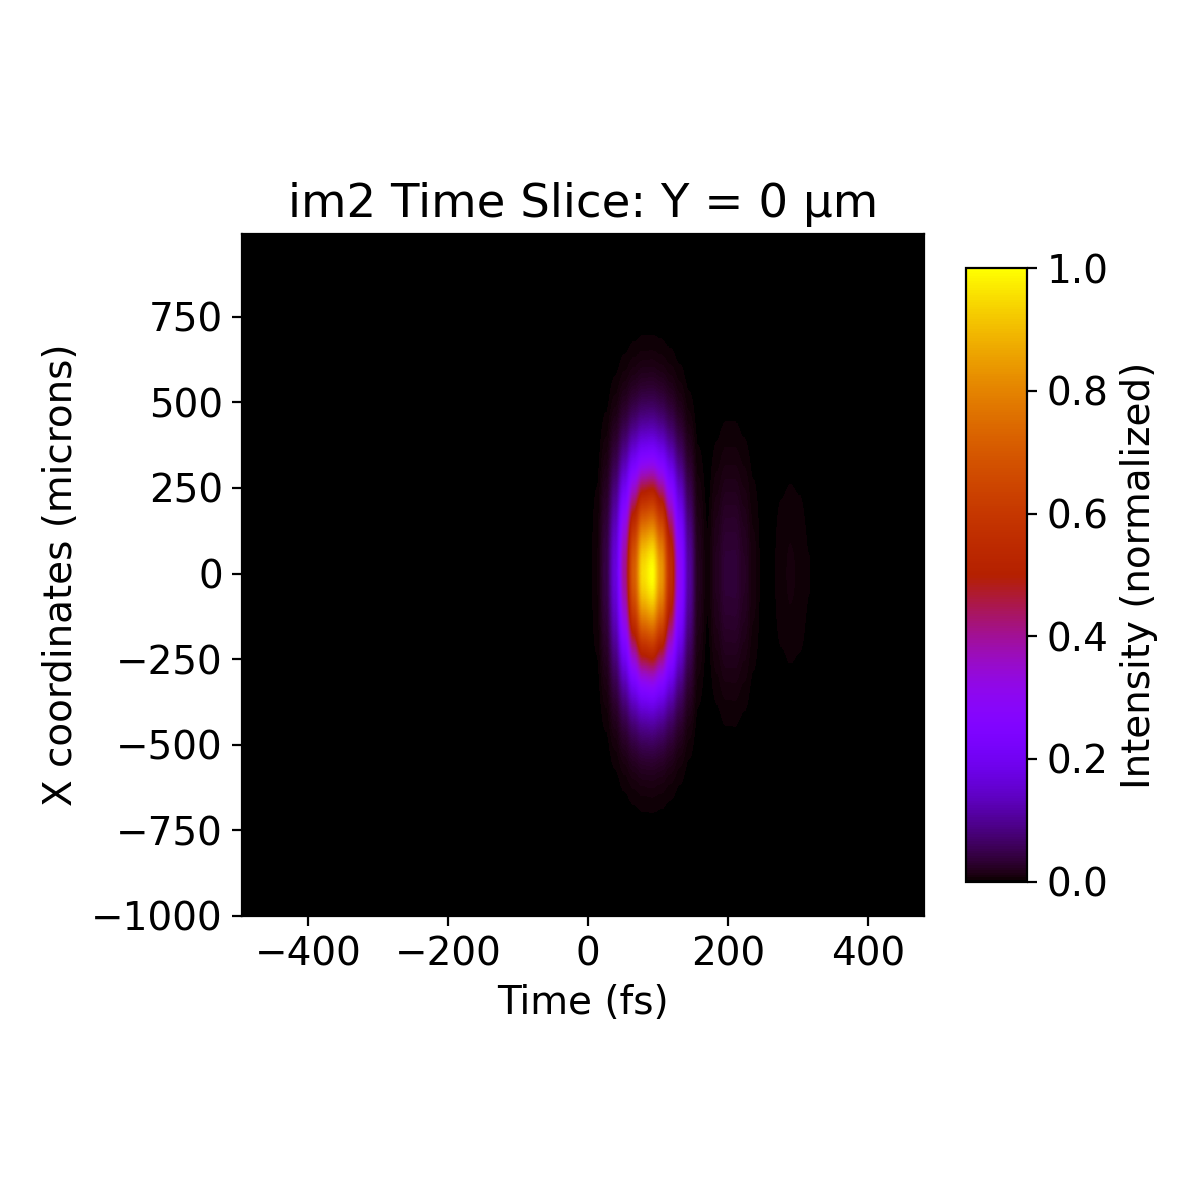

<IPython.core.display.Javascript object>


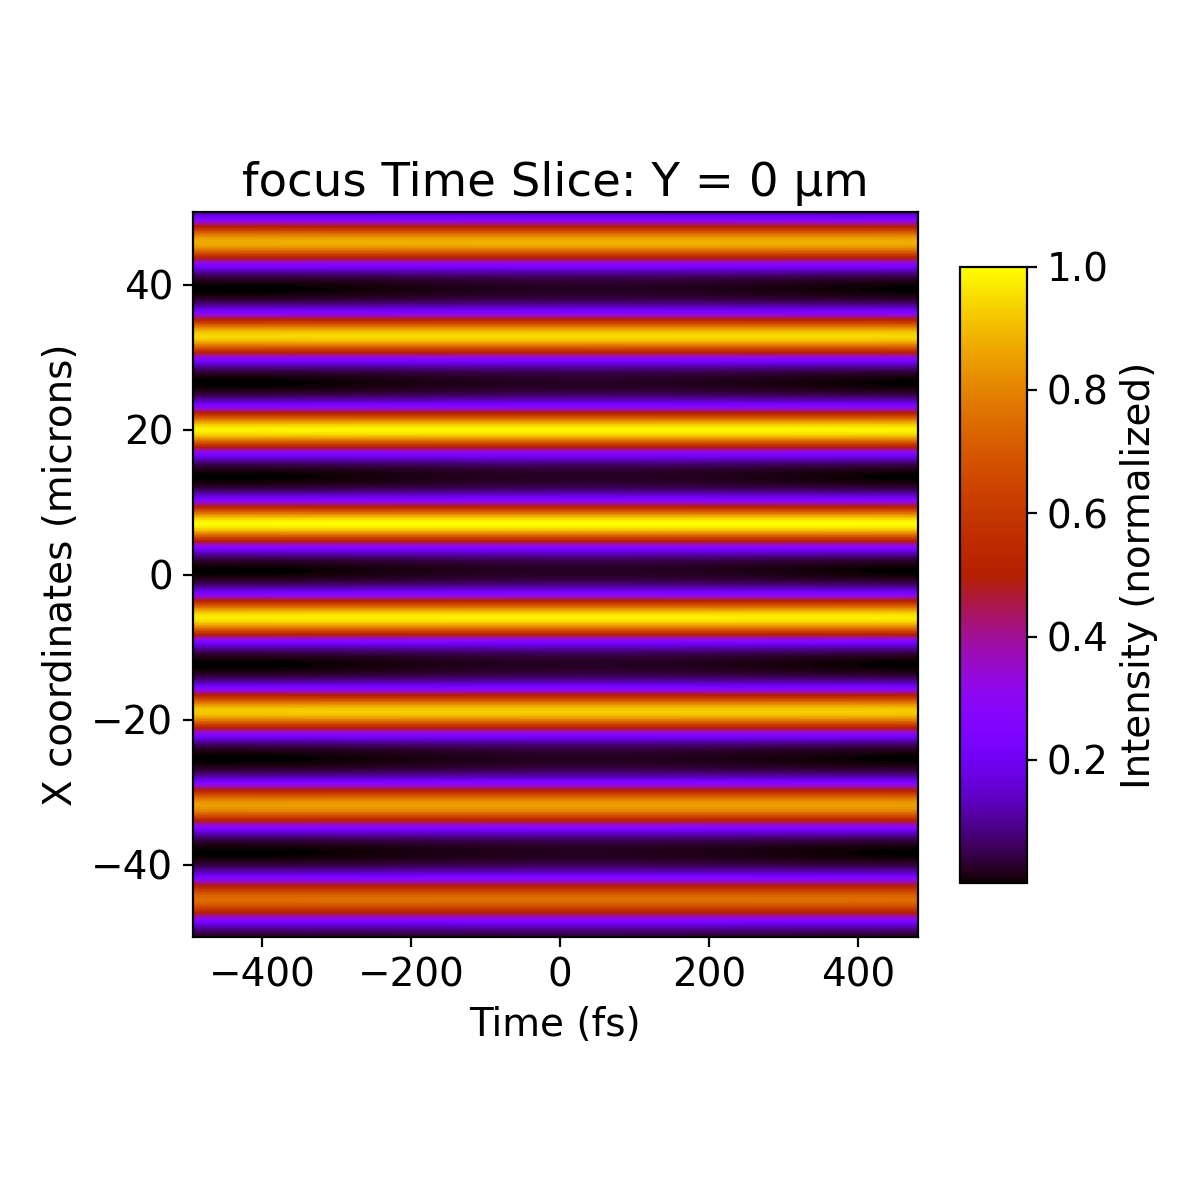

<IPython.core.display.Javascript object>


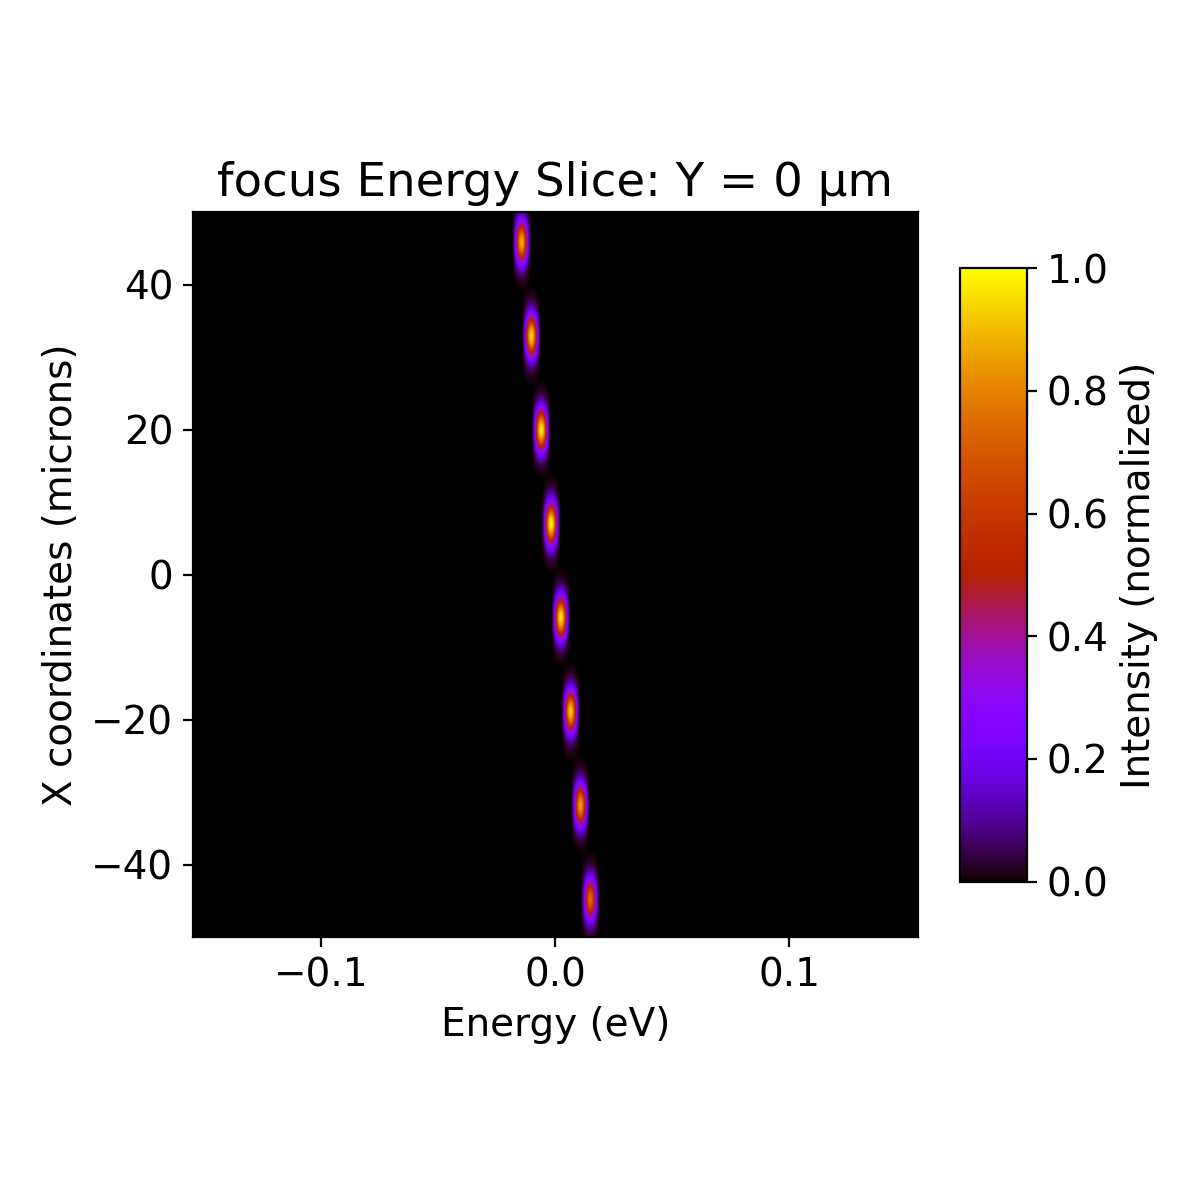

<IPython.core.display.Javascript object>


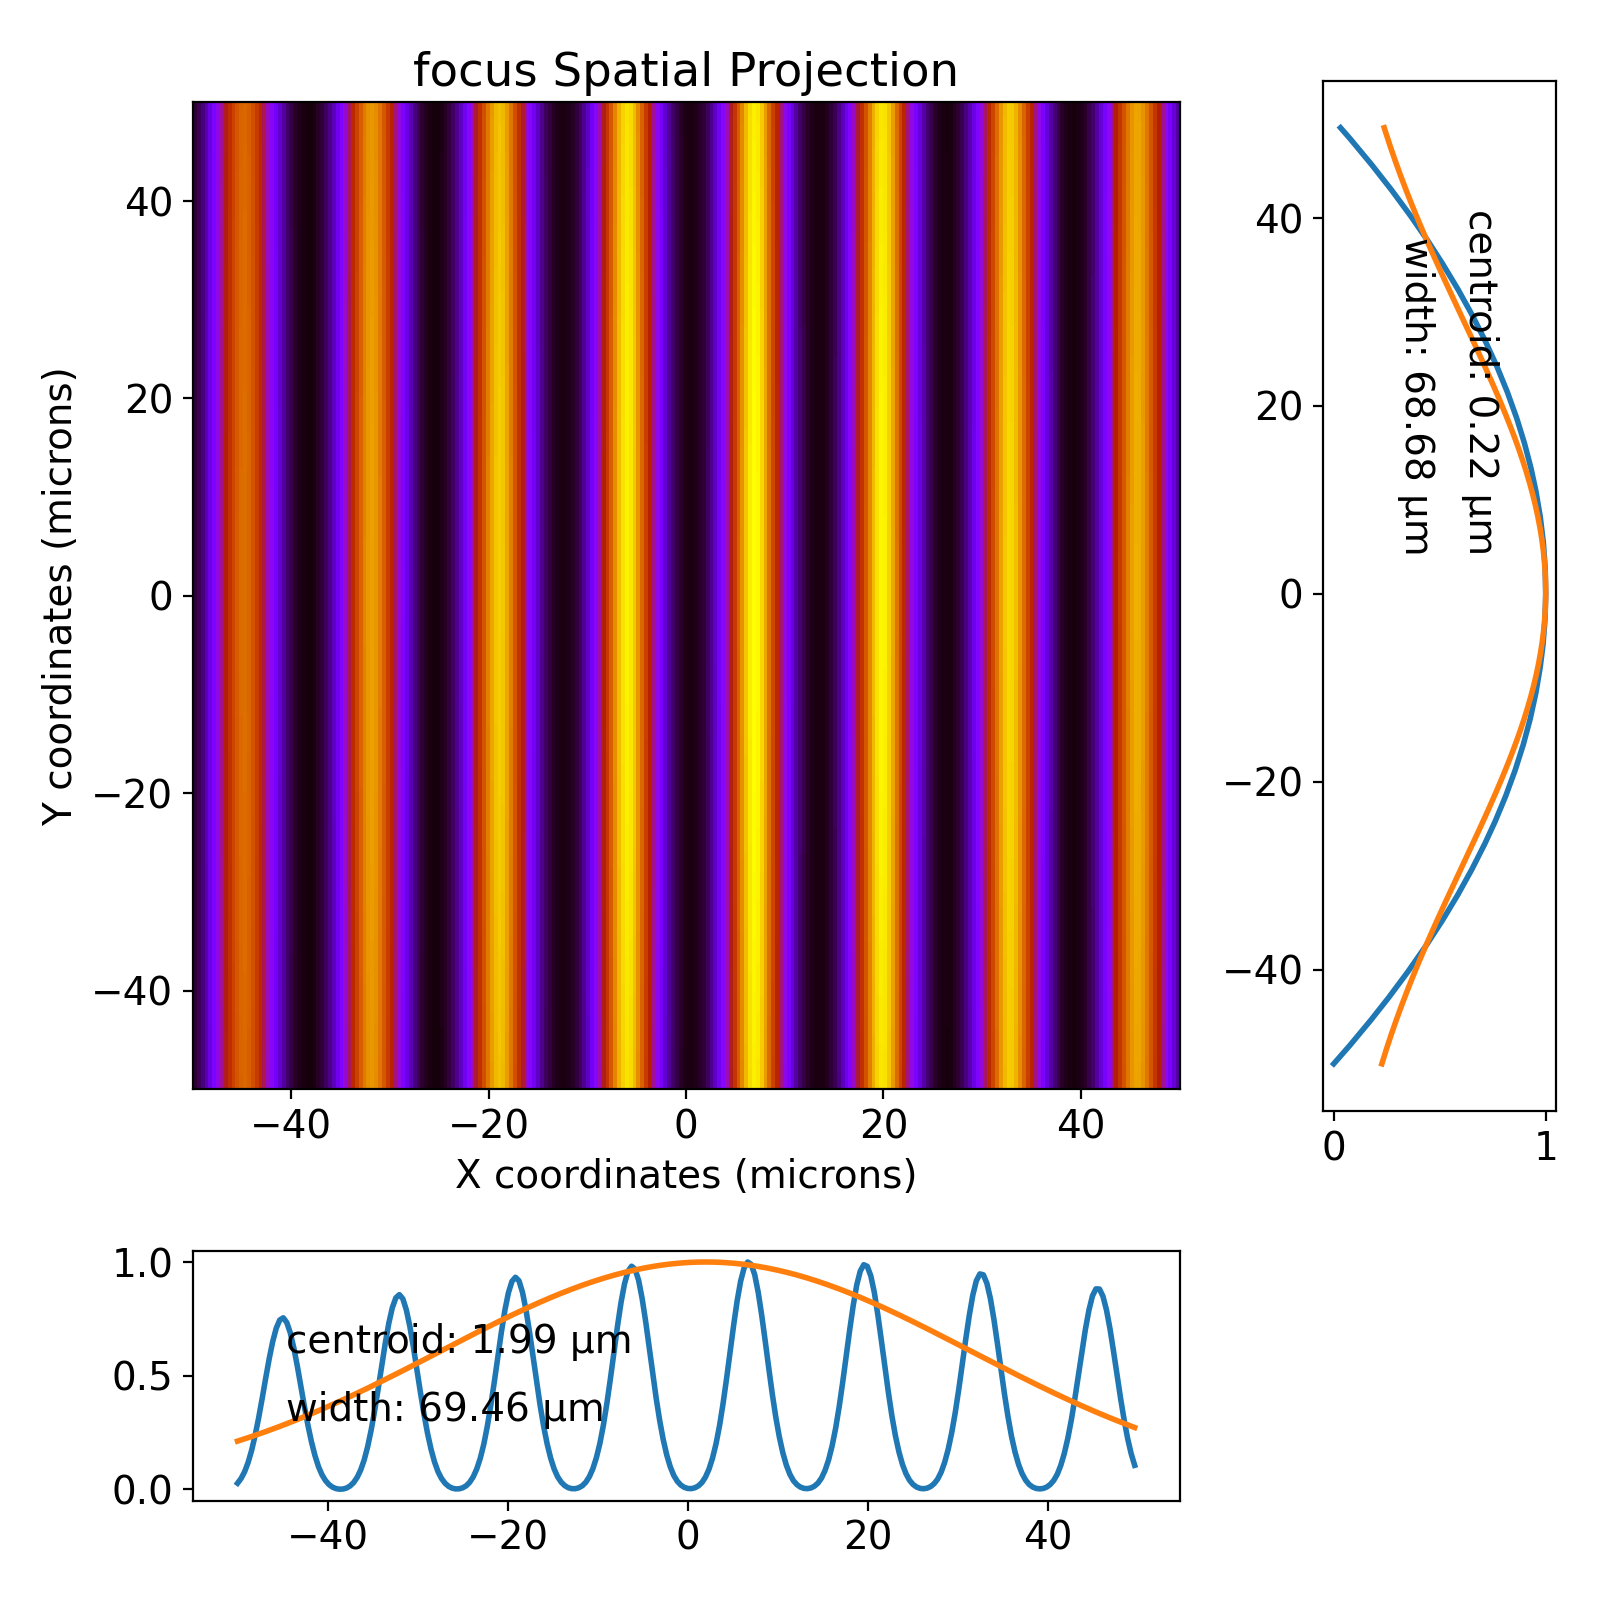

-0.00032345701309689914


In [18]:
pulse.imshow_projection('im2')
pulse.plot_pulse('im0')
pulse.plot_spectrum('im0')
# pulse.imshow_time_slice('im_c3')

# plot output pulse at beam center
pulse.plot_pulse('focus',shift=0)
pulse.plot_pulse('im2',shift=0)
# plt.savefig(fig_path+'option1_output_pulse_no_slit.png')
# plot output spectraum at beam center
pulse.plot_spectrum('im2')
# plt.savefig(fig_path+'option1_output_spectrum_no_slit.png')
# show spatial projection of output
# pulse.imshow_time_slice('im_c2',shift=-3000)
# plt.savefig(fig_path+'option1_output_spatial_no_slit.png')
# show time slice of output
# pulse.imshow_time_slice('im2')
# plt.savefig(fig_path+'option1_output_time_no_slit.png')
# show energy slice of output
# pulse.imshow_energy_slice('im2',dim='y')
# plt.savefig(fig_path+'option1_output_energy_no_slit.png')
# show spectral phase slice of output
pulse.imshow_energy_slice('im2',image_type='phase')
pulse.imshow_time_slice('im2')

pulse.imshow_time_slice('focus')
pulse.imshow_energy_slice('focus')
pulse.imshow_projection('focus')
# print(pulse.pulse_duration('im2'))
# # f1 = np.linspace(2.88, 2.887, 50)
# # print(f1)
# print(pulse.pulsefront_tilt('im2'))
print(pulse.spatial_chirp('focus'))

In [45]:
print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

crystal 2 incidence angle: 72.43 degrees
crystal 2 exit angle: 13.43 degrees


In [46]:
crystal2.d

9.600338905121083e-11

In [12]:
dE = 30
E = 9481
lambda0 = 1239.8/E*1e-9
lambda1 = 1239.8/(E+dE)*1e-9
alphaAsym = 29.5*np.pi/180
alpha0 = crystal2.alpha
beta0 = np.arcsin( np.sin(alpha0) - lambda0*np.sin(alphaAsym)/crystal2.d )
beta1 = np.arcsin( np.sin(alpha0) - lambda1*np.sin(alphaAsym)/crystal2.d )
print(beta1-beta0)
f = 10
dz = f*(1/np.cos(beta1-beta0) - 1)
print(dz)
dt = dz/3e8*1e15
print(dt)

0.0022062811526485926
2.4338431985349018e-05
81.12810661783006


In [20]:
print(Lambda)

1.9496099867975202e-10


In [90]:
print(crystal2.alpha)
print(crystal2.beta0)

print(crystal2.alpha+crystal2.beta0)

1.2641101510361068
0.23448464050278972
1.4985947915388964


In [91]:
alphaAsym

0.5148721293383272

In [92]:
np.sin(np.arccos(lambda0*np.sin(alphaAsym)/crystal1.d+np.cos(alpha0)))

0.23234176011161006

In [93]:
crystal1.alpha

0.7492421541043374

In [27]:
crystal2.alpha

1.2641101510361068

In [95]:
(np.pi/2-np.arccos(lambda0/Lambda+np.cos(alpha0)))**2

1.7857289229208544

In [96]:
lambda0/Lambda+np.sin(np.pi/2-alpha0)

0.9726342100236033

In [97]:
1-((lambda0/Lambda+np.sin(np.pi/2-alpha0)))**2

0.05398269349176121

In [98]:
1-np.sin(np.pi/2-crystal2.beta0)**2

0.05398269349176099

<IPython.core.display.Javascript object>


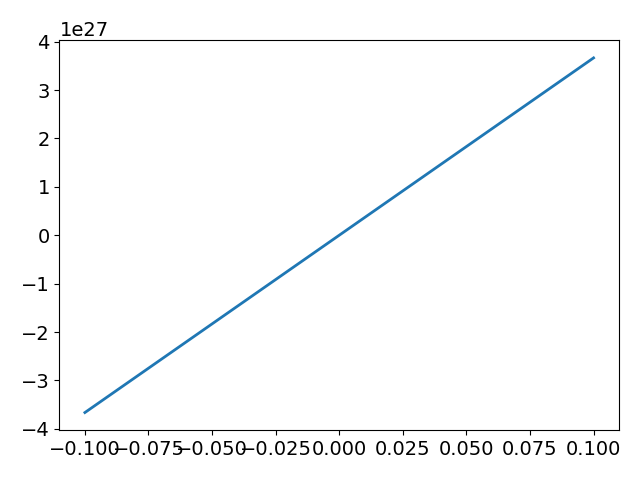

In [24]:
z1 = np.linspace(-.1,.1,100)
L = z1
Lambda = 1/(np.sin(alphaAsym)/crystal2.d)
sigma = 50e-6
GDD = -(lambda0**3*L*4)/(2*np.pi*(3e8)**2*Lambda**2)*(1-((lambda0/Lambda+np.sin(np.pi/2-alpha0)))**2)**(-3/2)*(1e15)**2
beta = lambda0/(sigma*2*np.pi*np.cos(np.pi/2-crystal2.alpha))
# GDD = -(lambda0**3*L*4)/(2*np.pi*(3e8)**2*Lambda**2)*(1e15)**2*.054**(-3/2)
# GDD = -(lambda0**3*L*4)/(2*np.pi*(3e8)**2*Lambda**2)*(1-np.sin(np.pi/2-crystal2.beta0)**2)**(-3/2)*(1e15)**2

k = 2*np.pi/lambda0
GDD = k*beta**2*2*(2*z1)*(1e15)**2
plt.figure()
plt.plot(z1,GDD)

<IPython.core.display.Javascript object>


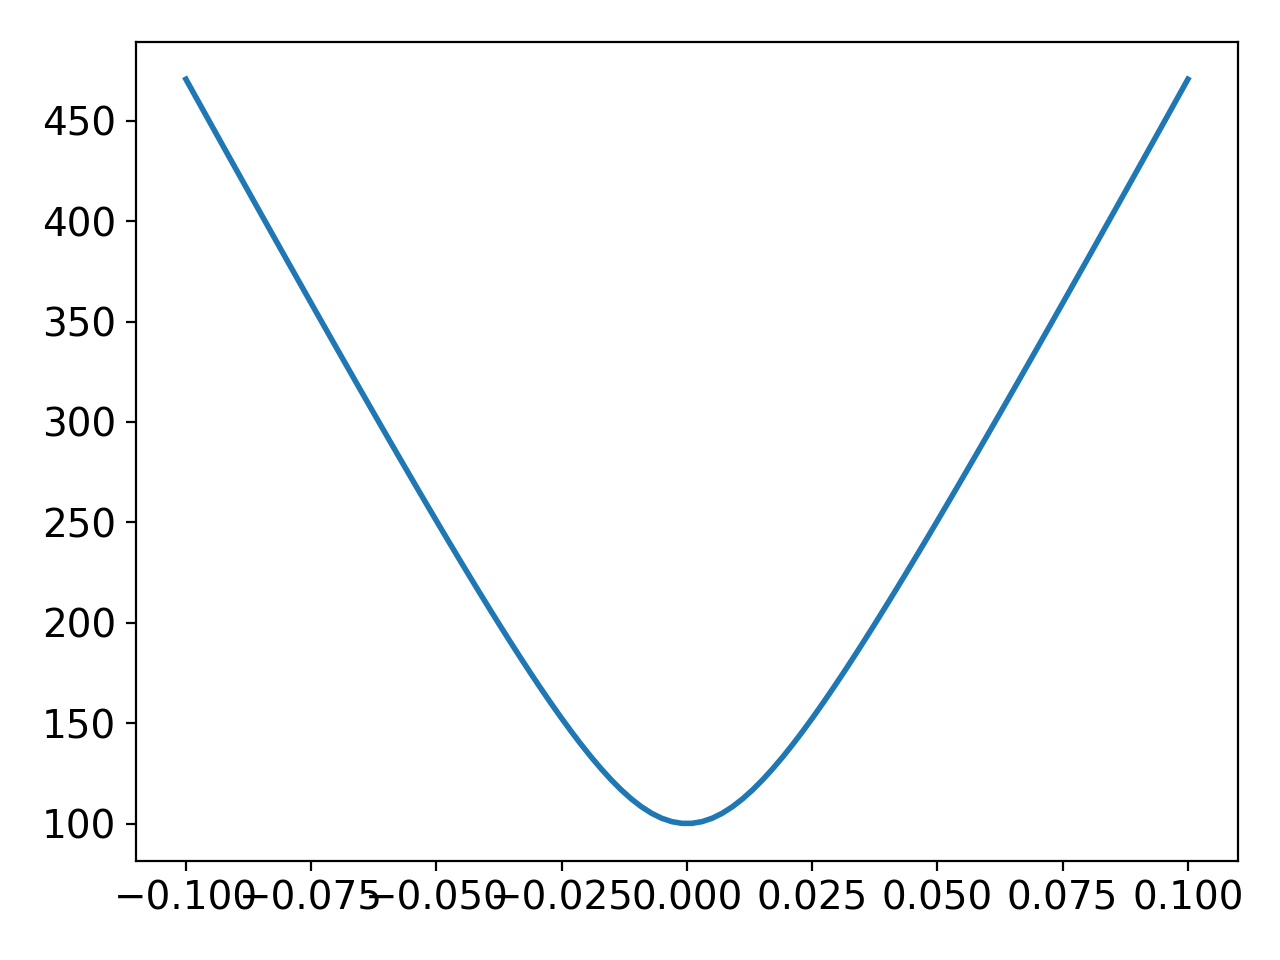

In [137]:
dt = 100

dt_out = np.sqrt(dt**4 + 16*np.log(2)**2*(GDD*5)**2)/dt
plt.figure()
plt.plot(L,dt_out)

In [25]:
np.sin(alpha0)/np.sin(crystal2.beta0)

4.103176498680354

In [75]:
2*np.log(2)*4*(1239.8/9500*1e-9)*10/np.pi/1e-3*1e6

2.303528564793747